# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append('./..')
sys.path.append('./../..')
import logging

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact

import dynaphos
from dynaphos import utils
from dynaphos import cortex_models
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator


import math

# Simulator

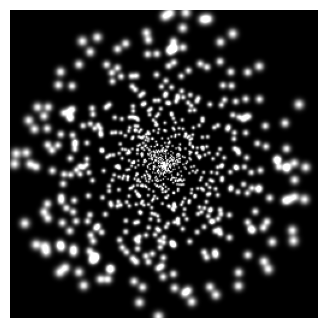

In [2]:
# Load the simulator configuration file (and adjust to preferences).
params = utils.load_params('../config/params.yaml')

# Get phosphene coordinates...
n_phosphenes = 1024
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)

# Initialize simulator
simulator = PhospheneSimulator(params, phosphene_coords)

# Stimulation amplitude
amplitude = params['sampling']['stimulus_scale'] # Ampère (160 µA)

# Stimulation vector
stim = amplitude * torch.ones(n_phosphenes).cuda().detach() # (All electrodes are activated)

# Reset and call the simulator
simulator.reset()
phosphenes = simulator(stim)

# Show the phosphene image
plt.figure(figsize=(4, 4))
plt.imshow(phosphenes.cpu(), cmap='gray')
plt.axis('off')
plt.show()

# Uniformity

In [3]:
from phosphene.uniformity import DynamicAmplitudeNormalizer

Loss = 0.0299:   0%|                                                                                                                                                                                                                                                      | 0/2000 [00:00<?, ?iter/s]

Loss = 0.0029: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 231.18iter/s]


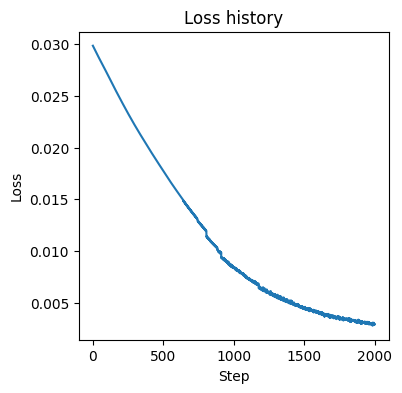

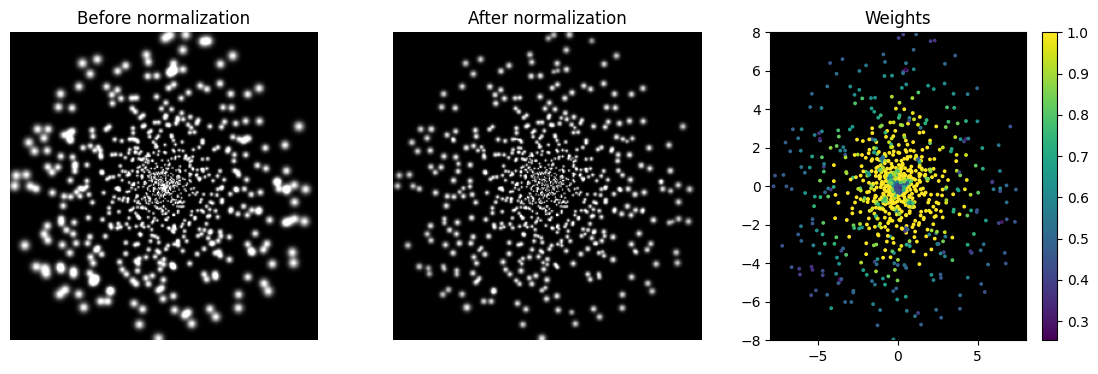

Percentage of amplitude: 76.04%


In [4]:
stim_init = amplitude * torch.ones(simulator.num_phosphenes, device='cuda')

normalizer = DynamicAmplitudeNormalizer(
    simulator=simulator,
    base_size=3,
    scale=0.0001,
    A_min=0,
    A_max=amplitude,
    learning_rate=0.002,
    steps=2000,
    target=None  # or a specific float
)
stim_final = normalizer.run(stim_init, verbose=True)
stim_weights = normalizer.weights

# plot the loss_history from the normalizer
plt.figure(figsize=(4, 4))
plt.plot(normalizer.loss_history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss history')
plt.show()

# Visualize
simulator.reset()
phos_image_before = simulator(stim_init)
simulator.reset()
phos_image_after  = simulator(stim_init * stim_weights)

# visualize the phosphene images and the weights in a scatterplot
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.imshow(phos_image_before.cpu(), cmap='gray')
plt.axis('off')
plt.title('Before normalization')

plt.subplot(1, 3, 2)
plt.imshow(phos_image_after.cpu(), cmap='gray')
plt.axis('off')
plt.title('After normalization')

plt.subplot(1, 3, 3)
phosphene_coords = simulator.coordinates
plt.scatter(phosphene_coords._x, -phosphene_coords._y, c=stim_weights.cpu(), cmap='viridis', s=3)
# extend the axes to the full image size
fov = simulator.params['run']['view_angle']
plt.xlim(-fov/2, fov/2)
plt.ylim(-fov/2, fov/2)
# black background
plt.gca().set_facecolor('black')
plt.colorbar()
plt.title('Weights')
plt.show()

# percentage of amplitude compared to full amplitude
print(f'Percentage of amplitude: {stim_weights.sum() / simulator.num_phosphenes*100:.2f}%')

# Phosphene Density Maps

In [5]:
from phosphene.density import VisualFieldMapper

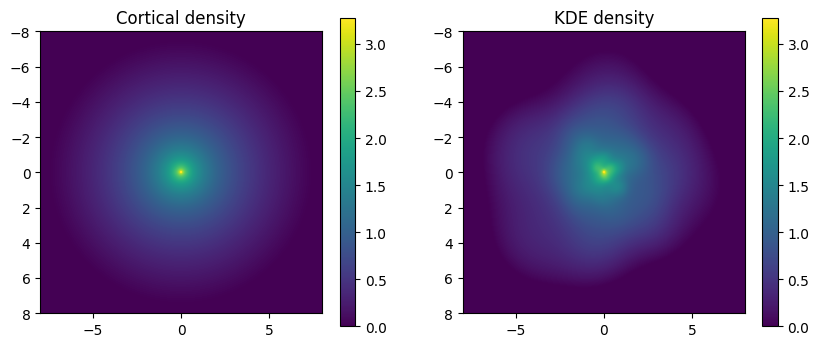

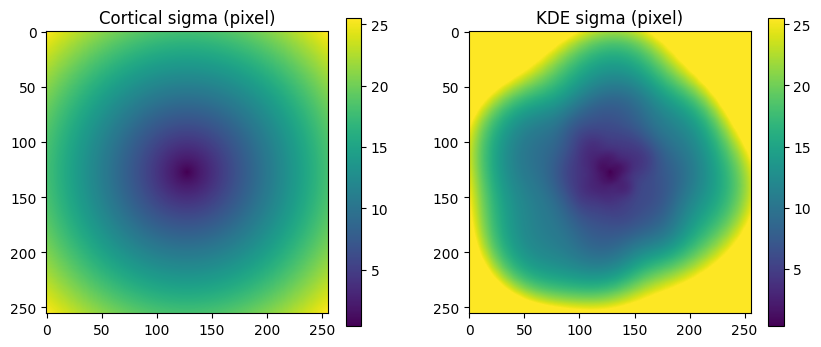

In [6]:
mapper = VisualFieldMapper(simulator=simulator)

# 1) Cortical approach:
density_cortical = mapper.build_density_map_cortical(total_phosphenes=1024)
sigma_cortical_fov = mapper.build_sigma_map_from_density(density_cortical, space="fov")
sigma_cortical_pix = mapper.build_sigma_map_from_density(density_cortical, space="pixel")

# 2) KDE approach:
density_kde = mapper.build_density_map_kde(k=16, alpha=1.0, total_phosphenes=1024)
sigma_kde_fov = mapper.build_sigma_map_from_density(density_kde, space="fov")
sigma_kde_pix = mapper.build_sigma_map_from_density(density_kde, space="pixel")

# show density maps
fov = params['run']['view_angle']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.log10(density_cortical), cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmin=0)
plt.colorbar()
plt.title('Cortical density')

plt.subplot(1, 2, 2)
plt.imshow(np.log10(density_kde), cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmax=np.log10(density_cortical.max()), vmin=0)
plt.colorbar()
plt.title('KDE density')
plt.show()

# plot sigma_cortical_pix, sigma_kde_pix
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sigma_cortical_pix, cmap='viridis')
plt.colorbar()
plt.title('Cortical sigma (pixel)')

plt.subplot(1, 2, 2)
plt.imshow(sigma_kde_pix, cmap='viridis', vmax=sigma_cortical_pix.max())
plt.colorbar()
plt.title('KDE sigma (pixel)')
plt.show()

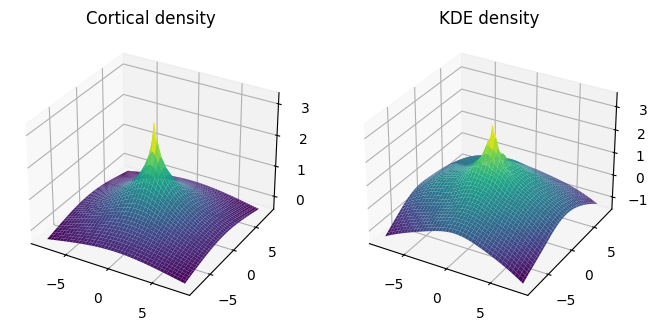

In [7]:
# 3d plot of the cortical density maps
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(np.linspace(-fov/2, fov/2, density_cortical.shape[1]), np.linspace(-fov/2, fov/2, density_cortical.shape[0]))
ax.plot_surface(X, Y, np.log10(density_cortical), cmap='viridis')
ax.set_title('Cortical density')

ax = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(np.linspace(-fov/2, fov/2, density_kde.shape[1]), np.linspace(-fov/2, fov/2, density_kde.shape[0]))
ax.plot_surface(X, Y, np.log10(density_kde), cmap='viridis')
ax.set_title('KDE density')
plt.show()

# Image processing for Phosphene Vision

In [8]:
from data.local_datasets import LaPaDataset
from spatial_frequency.components.modulated_conv2d import UnifiedInputModulation
import yaml

def load_config(yaml_file):
    with open(yaml_file) as file:
        raw_content = yaml.load(file,Loader=yaml.FullLoader) # nested dictionary
    return {k:v for params in raw_content.values() for k,v in params.items()} # unpacked


cfg = load_config('../config/256x256_LaPa.yaml')
LaPa_dataset = LaPaDataset(cfg)

In [9]:
def robust_percentile_normalization(electrode, amplitude, threshold, low_perc=5, high_perc=95, gamma=1.0):
    """
    Normalize the stimulation vector in a robust, contrast-preserving way.

    This function performs the following steps:
      1. Subtracts a given threshold (values below threshold become 0).
      2. Computes low and high percentiles (e.g., 5th and 95th) of the resulting values.
      3. Linearly scales values between these percentiles to [0, 1], then applies an optional gamma correction.
      4. Scales the result to the desired amplitude.

    Args:
        electrode (torch.Tensor): Input stimulation values.
        amplitude (float): Desired maximum amplitude.
        threshold (float): Activation threshold (e.g. your activation_threshold).
        low_perc (float): Lower percentile (default 5).
        high_perc (float): Upper percentile (default 95).
        gamma (float): Gamma exponent for power-law scaling (default 1.0 means linear scaling).
        
    Returns:
        torch.Tensor: Normalized stimulation values, with zeros preserved.
    """
    # Subtract threshold and clamp to 0 so that values below threshold remain 0.
    above_thresh = electrode - threshold
    above_thresh = torch.clamp(above_thresh, min=0.0)
    
    # Compute robust lower and upper bounds using percentiles.
    # Use torch.quantile (available in PyTorch 1.7+; adjust if needed).
    low_val = torch.quantile(above_thresh, low_perc / 100.0)
    high_val = torch.quantile(above_thresh, high_perc / 100.0)
    
    # Avoid division by zero if high_val == low_val.
    range_val = high_val - low_val + 1e-8

    # Linearly map values in the range [low_val, high_val] to [0, 1]
    normalized = (above_thresh - low_val) / range_val
    normalized = torch.clamp(normalized, 0.0, 1.0)

    # Apply gamma correction to adjust contrast if needed.
    normalized = normalized ** gamma

    # Scale to the desired amplitude.
    normalized = normalized * amplitude

    return normalized


# Dilation is used for the reg-loss on the phosphene image: phosphenes do not have to map 1 on 1, small offset is allowed.
def dilation5x5(img, kernel=None):
    if kernel is None:
        kernel = torch.tensor([[[[0., 0., 1., 0., 0.],
                              [0., 1., 1., 1., 0.],
                              [1., 1., 1., 1., 1.],
                              [0., 1., 1., 1., 0.],
                              [0., 0., 1., 0., 0.]]]], requires_grad=False, device=img.device)
    return torch.clamp(torch.nn.functional.conv2d(img, kernel, padding=kernel.shape[-1]//2), 0, 1)

def dilation3x3(img, kernel=None):
    if kernel is None:
        kernel = torch.tensor([[[
                              [ 0, 1., 0.],
                              [ 1., 1., 1.],
                              [ 0., 1., 0.],]]], requires_grad=False, device=img.device)
    return torch.clamp(torch.nn.functional.conv2d(img, kernel, padding=kernel.shape[-1]//2), 0, 1)

In [10]:
sigma_map_tensor = torch.tensor(sigma_kde_pix).float().cuda().detach()

layer = UnifiedInputModulation(
    kernel_size=119,
    kernel_type="log",
    sigma_map=sigma_map_tensor,
    dilation=1,
    padding_mode='reflect'
).cuda()
layer.eval()

sigma_map_tensor = torch.tensor(sigma_kde_pix).float().cuda().detach()

layer_gauss = UnifiedInputModulation(
    kernel_size=119,
    kernel_type="gaussian",
    sigma_map=sigma_map_tensor,
    dilation=1,
    padding_mode='reflect'
).cuda()
layer_gauss.eval()

UnifiedInputModulation()

We are going to compare 3 types of image processing:
- Input image thresholding
- Ground truth outlines
- LoG filtered

We will calculate the SSIM between the input and the phosphene images.
We will also calculate the SSIM between the phosphene images and the filtered images.

In [11]:
def rand_perlin_2d(shape, res, fade = lambda t: 6*t**5 - 15*t**4 + 10*t**3):
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    
    grid = torch.stack(torch.meshgrid(torch.arange(0, res[0], delta[0]), torch.arange(0, res[1], delta[1])), dim = -1) % 1
    angles = 2*math.pi*torch.rand(res[0]+1, res[1]+1)
    gradients = torch.stack((torch.cos(angles), torch.sin(angles)), dim = -1)
    
    tile_grads = lambda slice1, slice2: gradients[slice1[0]:slice1[1], slice2[0]:slice2[1]].repeat_interleave(d[0], 0).repeat_interleave(d[1], 1)
    dot = lambda grad, shift: (torch.stack((grid[:shape[0],:shape[1],0] + shift[0], grid[:shape[0],:shape[1], 1] + shift[1]  ), dim = -1) * grad[:shape[0], :shape[1]]).sum(dim = -1)
    
    n00 = dot(tile_grads([0, -1], [0, -1]), [0,  0])
    n10 = dot(tile_grads([1, None], [0, -1]), [-1, 0])
    n01 = dot(tile_grads([0, -1],[1, None]), [0, -1])
    n11 = dot(tile_grads([1, None], [1, None]), [-1,-1])
    t = fade(grid[:shape[0], :shape[1]])
    return math.sqrt(2) * torch.lerp(torch.lerp(n00, n10, t[..., 0]), torch.lerp(n01, n11, t[..., 0]), t[..., 1])

In [12]:
image_processing_dict = {}

threshold = params['thresholding']['rheobase']

for image_index, batch in enumerate(LaPa_dataset):
    image = batch['image'].unsqueeze(0)
    contour = batch['contour'].unsqueeze(0)

    # dilate the contour 5x5
    contour = dilation5x5(contour)
    # contour = modified_cdf_normalization(contour, 1)

    LoG = layer(image).clip(0, None)
    LoG = (LoG - LoG.min()) / (LoG.max() - LoG.min())
    LoG = LoG.max(1, keepdim=True).values

    grayscale = image.mean(dim=1, keepdim=True)
    grayscale_gauss = layer_gauss(grayscale).clip(0, None)

    canny_edge = cv2.Canny((image*255).squeeze(0).permute(1,2,0).cpu().numpy().astype(np.uint8), 100, 200)
    canny_edge = torch.tensor(canny_edge).float().cuda().detach()
    canny_edge = canny_edge / canny_edge.max()
    canny_edge = canny_edge.unsqueeze(0).unsqueeze(0)

    random_image = rand_perlin_2d((256, 256), (4, 4)).unsqueeze(0).unsqueeze(0).cuda().detach()
    random_image = (random_image - random_image.min()) / (random_image.max() - random_image.min())

    # 1) Grayscale
    simulator.reset()
    grayscale_electrode = simulator.sample_stimulus(grayscale, rescale=True)
    grayscale_electrode = robust_percentile_normalization(grayscale_electrode, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
    grayscale_electrode = grayscale_electrode * stim_weights
    grayscale_phosphenes = simulator(grayscale_electrode).unsqueeze(0).unsqueeze(0)

    # 1.5) Gaussian
    simulator.reset()
    grayscale_gauss_electrode = simulator.sample_stimulus(grayscale_gauss, rescale=True)
    grayscale_gauss_electrode = robust_percentile_normalization(grayscale_gauss_electrode, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
    grayscale_gauss_electrode = grayscale_gauss_electrode * stim_weights
    grayscale_gauss_phosphenes = simulator(grayscale_gauss_electrode).unsqueeze(0).unsqueeze(0)

    # 2) Contour
    simulator.reset()
    contour_electrode = simulator.sample_stimulus(contour, rescale=True)
    contour_electrode = robust_percentile_normalization(contour_electrode, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
    contour_electrode = contour_electrode * stim_weights
    contour_phosphenes = simulator(contour_electrode).unsqueeze(0).unsqueeze(0)

    # 2.5) Canny edge
    simulator.reset()
    canny_edge_electrode = simulator.sample_stimulus(canny_edge, rescale=True)
    canny_edge_electrode = robust_percentile_normalization(canny_edge_electrode, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
    canny_edge_electrode = canny_edge_electrode * stim_weights
    canny_edge_phosphenes = simulator(canny_edge_electrode).unsqueeze(0).unsqueeze(0)

    # 3) LoG response
    simulator.reset()
    LoG_electrode = simulator.sample_stimulus(LoG, rescale=True)
    LoG_electrode = robust_percentile_normalization(LoG_electrode, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
    LoG_electrode = LoG_electrode * stim_weights
    LoG_phosphenes = simulator(LoG_electrode).unsqueeze(0).unsqueeze(0)

    # Sanity check: randomize the stimulation vector
    simulator.reset()
    random_electrode = simulator.sample_stimulus(random_image, rescale=True)
    random_electrode = robust_percentile_normalization(random_electrode, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
    random_electrode = random_electrode * stim_weights
    random_phosphenes = simulator(random_electrode).unsqueeze(0).unsqueeze(0)
       


    image_processing_dict[image_index] = {
    'image': image,
    'grayscale': {
        'stim': grayscale,
        'phosphenes': grayscale_phosphenes
    },
    'grayscale_gauss': {
        'stim': grayscale_gauss,
        'phosphenes': grayscale_gauss_phosphenes
    },
    'contour': {
        'stim': contour,
        'phosphenes': contour_phosphenes
    },
    'canny_edge': {
        'stim': canny_edge,
        'phosphenes': canny_edge_phosphenes
    },
    'LoG_response': {
        'stim': LoG,
        'phosphenes': LoG_phosphenes
    },
    'random': {
        'stim': random_image,
        'phosphenes': random_phosphenes
    } 
    }
    
    if image_index == 5:
        break

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [13]:
key=5

stim_list = [image_processing_dict[image_index][key]['stim'] for key in image_processing_dict[image_index].keys() if key != 'image']
phos_list = [image_processing_dict[image_index][key]['phosphenes'] for key in image_processing_dict[image_index].keys() if key != 'image']

# print all the shapes
print([stim.shape for stim in stim_list])
print([phos.shape for phos in phos_list])

[torch.Size([1, 1, 256, 256]), torch.Size([1, 1, 256, 256]), torch.Size([1, 1, 256, 256]), torch.Size([1, 1, 256, 256]), torch.Size([1, 1, 256, 256]), torch.Size([1, 1, 256, 256])]
[torch.Size([1, 1, 256, 256]), torch.Size([1, 1, 256, 256]), torch.Size([1, 1, 256, 256]), torch.Size([1, 1, 256, 256]), torch.Size([1, 1, 256, 256]), torch.Size([1, 1, 256, 256])]


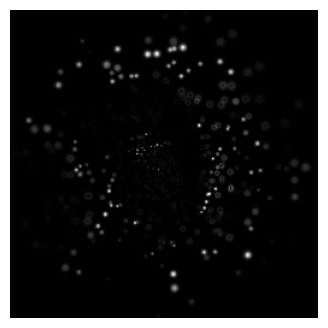

tensor(846.6793, device='cuda:0')

In [14]:
image_index = 0
phos_grayscale = image_processing_dict[image_index]['grayscale']['phosphenes']
phos_grayscale_gauss = image_processing_dict[image_index]['grayscale_gauss']['phosphenes']

difference = (phos_grayscale - phos_grayscale_gauss).abs()
plt.figure(figsize=(4, 4))
plt.imshow(difference.cpu()[0,0], cmap='gray')
plt.axis('off')
plt.show()

difference.sum()

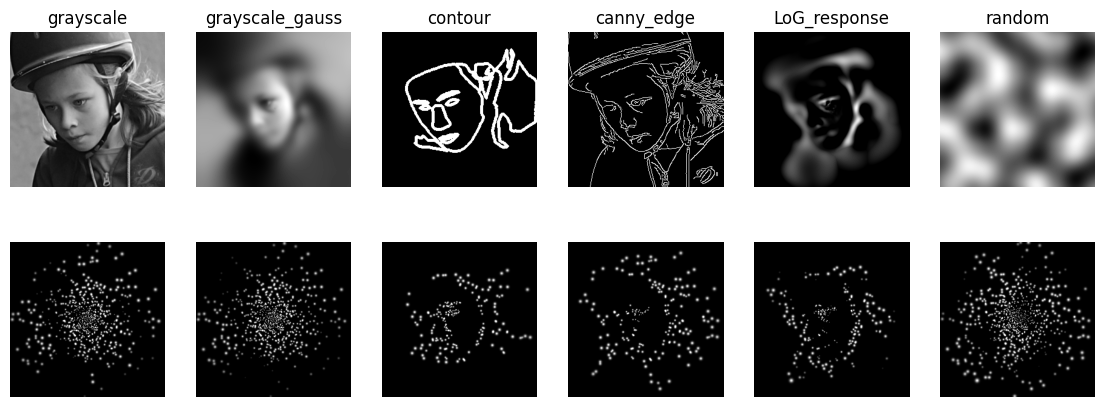

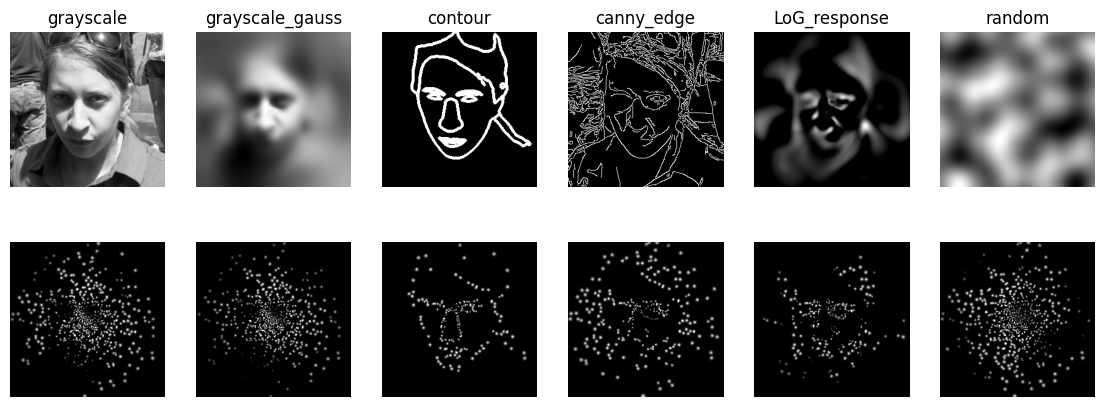

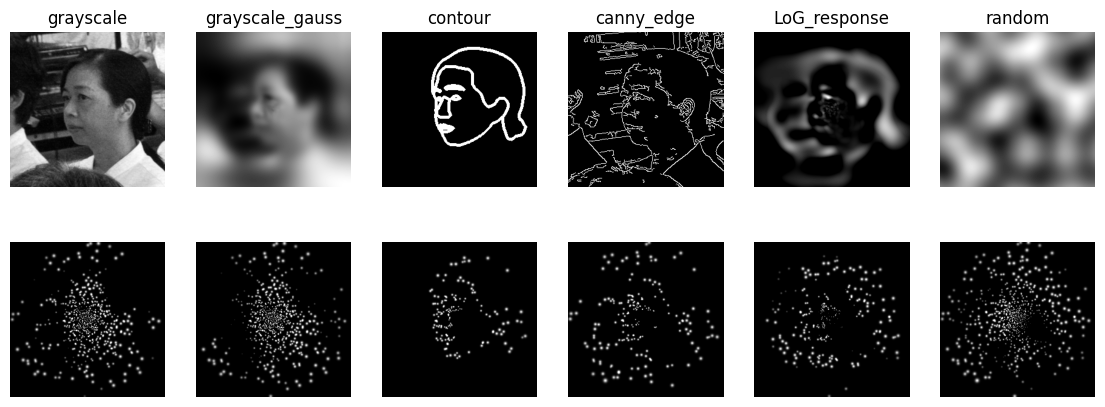

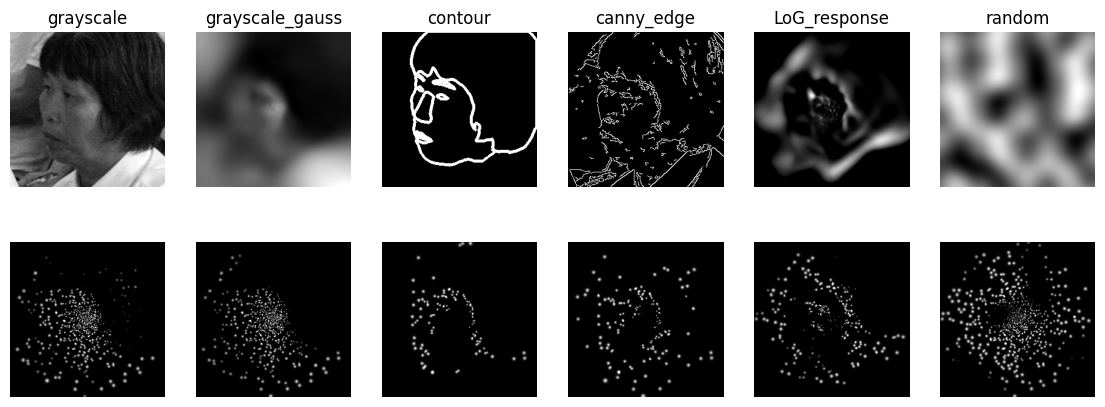

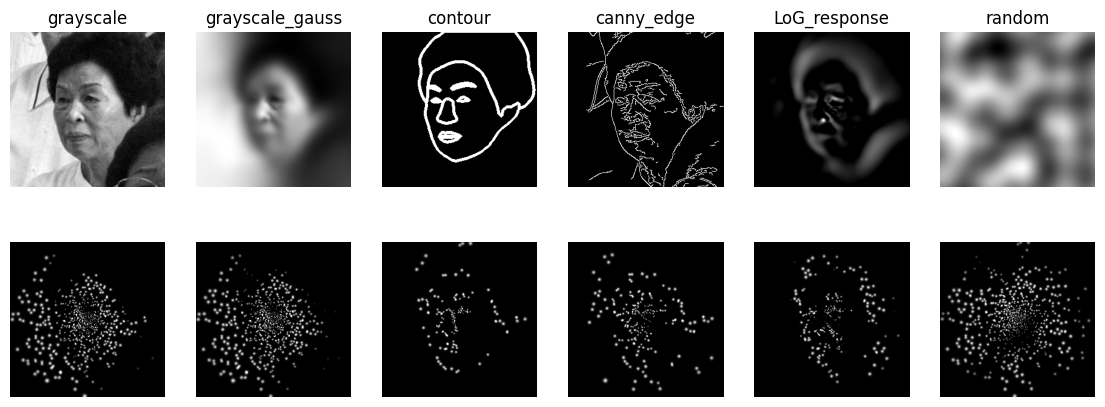

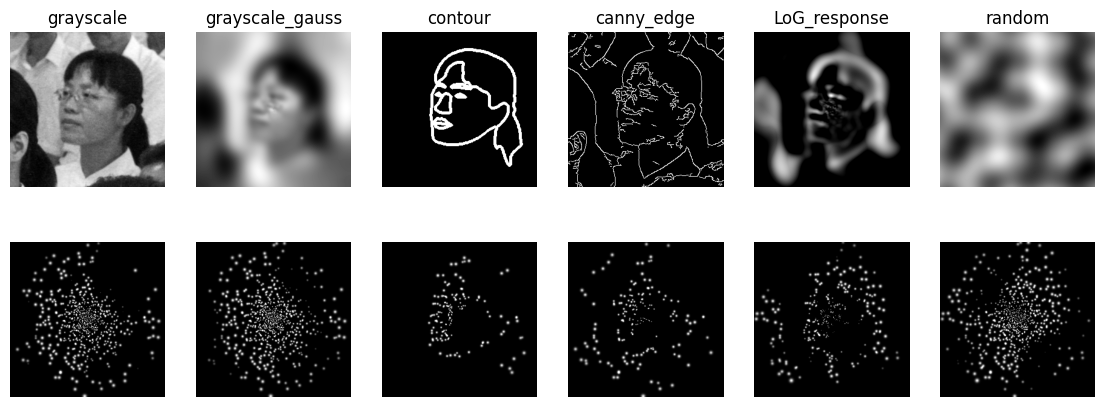

In [15]:
for image_index in list(image_processing_dict.keys()):
    stim_list = [image_processing_dict[image_index][key]['stim'] for key in image_processing_dict[image_index].keys() if key != 'image']
    phos_list = [image_processing_dict[image_index][key]['phosphenes'] for key in image_processing_dict[image_index].keys() if key != 'image']

    fig, axes = plt.subplots(2, len(stim_list), figsize=(14, 5))
    for i, (stim, phos) in enumerate(zip(stim_list, phos_list)):
        ax = axes[0, i]
        ax.imshow(stim[0,0].cpu().numpy(), cmap='gray')
        ax.axis('off')
        ax.set_title(list(image_processing_dict[image_index].keys())[1:][i])

        ax = axes[1, i]
        ax.imshow(phos[0,0].cpu().numpy(), cmap='gray')
        ax.axis('off')

    plt.show()   

# Evaluate

### Sliced Wasserstein Distance (SWD) for Evaluating Sparse Phosphene Images

The sliced Wasserstein distance (SWD) is an efficient alternative to the full Earth Mover’s Distance (EMD) that measures the dissimilarity between two probability distributions. In our application, we treat an image as a probability distribution by normalizing its pixel intensities so that the sum over all pixels equals 1. That is, given an image $I(x,y)$, we compute the normalized distribution as $P(x,y)=\frac{I(x,y)}{\sum_{x,y}I(x,y)}$. In this form, each pixel’s intensity represents the “mass” or probability at that location.

Instead of comparing images on a pixel-by-pixel basis, the SWD works by projecting these high-dimensional distributions onto many one-dimensional subspaces. For each random direction $\theta$, we project the pixel coordinates onto that line, computing the projected values $P_{\theta}(x,y)=\langle (x,y), \theta \rangle$. Then, we compute the 1D Wasserstein distance between the projected distributions. Finally, we average these distances over a number of random projections to obtain the SWD.

Mathematically, if we have two probability distributions $\mu$ and $\nu$, the sliced Wasserstein distance is defined as

$$
SW_p(\mu, \nu)=\left( \frac{1}{L}\sum_{l=1}^{L}W_p^p(P_{\theta_l\#}\mu,P_{\theta_l\#}\nu)\right)^{\frac{1}{p}},
$$

where $L$ is the number of random directions, $P_{\theta_l\#}\mu$ denotes the projection of $\mu$ onto the one-dimensional subspace defined by $\theta_l$, and $W_p$ is the 1D Wasserstein distance (which is efficiently computed by simply sorting the projected values).

This method is particularly well-suited for our sparse phosphene images because it does not depend solely on the histogram of intensities but also captures the spatial layout of the activated (bright) pixels. Even if two images have a similar overall intensity distribution, differences in the locations of the activations will be reflected in a higher SWD. In our experiments, a lower SWD indicates that the spatial distribution of activation in the phosphene image is closer to that of the target image.

In [16]:
def compute_sliced_wasserstein_distance(image1, image2, num_projections=100):
    """
    Compute the sliced Wasserstein distance (SWD) between two batches of images.
    
    Both image1 and image2 are torch.Tensors of shape (B, C, H, W) or (B, H, W), and should be 
    nonnegative and normalized so that the sum over spatial pixels (and channels, if applicable) is 1.
    
    The function treats each image as a distribution over pixel locations.
    It computes SWD for each image pair in the batch using num_projections random directions,
    and returns the average SWD over the batch.
    
    Args:
        image1, image2: torch.Tensor of shape (B, C, H, W) or (B, H, W).
        num_projections: int, number of random projections to use.
    
    Returns:
        swd: a scalar torch.Tensor representing the average sliced Wasserstein distance.
    """
    # If images have a channel dimension, convert to grayscale by averaging.
    if image1.dim() == 4:
        image1 = image1.mean(dim=1)  # shape: (B, H, W)
    if image2.dim() == 4:
        image2 = image2.mean(dim=1)

    # Normalize the images
    image1 = image1 / image1.sum(dim=(1, 2), keepdim=True)
    image2 = image2 / image2.sum(dim=(1, 2), keepdim=True)
        
    B, H, W = image1.shape
    N = H * W
    
    # Flatten the spatial dimensions for each image: shape (B, N)
    weights1 = image1.view(B, N)
    weights2 = image2.view(B, N)
    
    # Create a grid of pixel coordinates (shared by all images)
    # x coordinates vary along width, y coordinates along height.
    x_coords, y_coords = torch.meshgrid(torch.arange(W, device=image1.device).float(),
                                        torch.arange(H, device=image1.device).float(),
                                        indexing='xy')
    coords = torch.stack([x_coords.flatten(), y_coords.flatten()], dim=1)  # shape: (N, 2)
    
    # Generate random unit vectors (directions) for the projections.
    theta = torch.rand(num_projections, device=image1.device) * 2 * math.pi  # shape: (P,)
    directions = torch.stack([torch.cos(theta), torch.sin(theta)], dim=1)   # shape: (P, 2)
    
    # Compute the projection of each pixel coordinate onto each direction.
    # coords: (N, 2), directions.t(): (2, P)  -> (N, P), then transpose to (P, N).
    proj = (coords @ directions.t()).t()  # shape: (P, N)
    
    # Expand projections and weights for the batch:
    # We want proj: (P, B, N) and weights: (P, B, N)
    proj = proj.unsqueeze(1).expand(num_projections, B, N)
    w1 = weights1.unsqueeze(0).expand(num_projections, B, N)
    w2 = weights2.unsqueeze(0).expand(num_projections, B, N)
    
    # Sort the projections (and gather corresponding weights) along the last dimension.
    sorted_proj, indices = torch.sort(proj, dim=2)  # shape: (P, B, N)
    w1_sorted = torch.gather(w1, 2, indices)
    w2_sorted = torch.gather(w2, 2, indices)
    
    # Compute cumulative sums (CDFs) for each projection for each image.
    cdf1 = torch.cumsum(w1_sorted, dim=2)
    cdf2 = torch.cumsum(w2_sorted, dim=2)
    
    # Compute the absolute difference between the CDFs.
    diff_cdf = torch.abs(cdf1 - cdf2)  # shape: (P, B, N)
    
    # Compute the differences in sorted projection values (dx) along the last dimension.
    dx = sorted_proj[:, :, 1:] - sorted_proj[:, :, :-1]  # shape: (P, B, N-1)
    
    # Approximate the 1D Wasserstein distance for each projection:
    # For each projection, sum the product of dx and the difference in the CDF values (excluding the first element).
    wd_per_proj = torch.sum(diff_cdf[:, :, 1:] * dx, dim=2)  # shape: (P, B)
    
    # Average the Wasserstein distances over all projections for each image, then average over the batch.
    swd = torch.mean(wd_per_proj, dim=0)  # shape: (B,)
    return swd.mean()

In [17]:
torch.use_deterministic_algorithms(False)

image_index= 5

stim_images = [image_processing_dict[image_index][key]['stim'] for key in image_processing_dict[image_index].keys() if key != 'image']
phos_images = [image_processing_dict[image_index][key]['phosphenes'] for key in image_processing_dict[image_index].keys() if key != 'image']

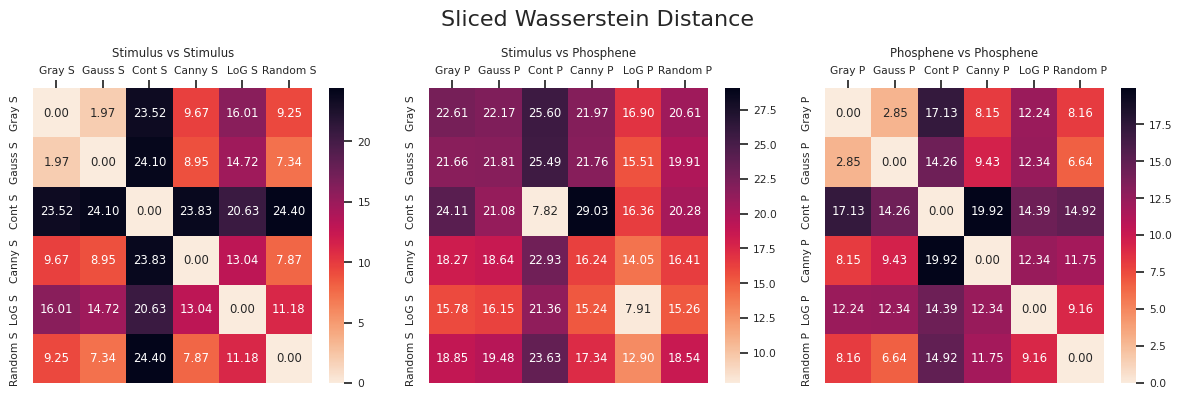

In [57]:
import seaborn as sns

# Labels for the conditions
labels_stim = ["Gray S", "Gauss S", "Cont S", "Canny S", "LoG S", "Random S"]
labels_phos = ["Gray P", "Gauss P", "Cont P", "Canny P", "LoG P", "Random P"]

# Assume these numpy arrays have been computed and normalized:
# Stimuli: grayscale_np, contour_np, log_np
# Phosphenes: grayscale_phosphene_np, contour_phosphene_np, LoG_phosphene_np
# And compute_sliced_wasserstein_distance(image1, image2, num_projections) is defined.
num_projections = 50

stim_stim_matrix = np.zeros((len(labels_stim), len(labels_stim)))
for i in range(len(labels_stim)):
    for j in range(i, len(labels_stim)):
        swd_val = compute_sliced_wasserstein_distance(stim_images[i], stim_images[j], num_projections=num_projections)
        stim_stim_matrix[i, j] = swd_val
        stim_stim_matrix[j, i] = swd_val

# 2. Stim vs Phosphene
stim_phos_matrix = np.zeros((len(labels_stim), len(labels_phos)))
for i in range(len(labels_stim)):
    for j in range(len(labels_phos)):
        swd_val = compute_sliced_wasserstein_distance(stim_images[i], phos_images[j], num_projections=num_projections)
        stim_phos_matrix[i, j] = swd_val

# 3. Phos vs Phos (symmetric)
phos_phos_matrix = np.zeros((len(labels_phos), len(labels_phos)))
for i in range(len(labels_phos)):
    for j in range(i, len(labels_phos)):
        swd_val = compute_sliced_wasserstein_distance(phos_images[i], phos_images[j], num_projections=num_projections)
        phos_phos_matrix[i, j] = swd_val
        phos_phos_matrix[j, i] = swd_val

# Plot the matrices
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.heatmap(stim_stim_matrix, annot=True, fmt=".2f", ax=axes[0], xticklabels=labels_stim, yticklabels=labels_stim, cmap='rocket_r')
sns.set(font_scale=0.7)
axes[0].set_title("Stimulus vs Stimulus")
axes[0].xaxis.tick_top()

sns.heatmap(stim_phos_matrix, annot=True, fmt=".2f", ax=axes[1], xticklabels=labels_phos, yticklabels=labels_stim, cmap='rocket_r')
axes[1].set_title("Stimulus vs Phosphene")
axes[1].xaxis.tick_top()

sns.heatmap(phos_phos_matrix, annot=True, fmt=".2f", ax=axes[2], xticklabels=labels_phos, yticklabels=labels_phos, cmap='rocket_r')
axes[2].set_title("Phosphene vs Phosphene")
axes[2].xaxis.tick_top()

# title
plt.suptitle("Sliced Wasserstein Distance", size=16)

plt.tight_layout()
plt.show()

### Gist descriptors

In [19]:
import torch.nn.functional as F
import math

def create_gabor_kernel(kernel_size, frequency, theta, sigma=None, phase=0, gamma=1.0, device='cpu'):
    """
    Create a Gabor kernel in PyTorch.
    
    Parameters:
      kernel_size : int
          The size of the kernel (must be odd).
      frequency : float
          The frequency (1/λ) of the sinusoid.
      theta : float
          The orientation of the Gabor kernel (in radians).
      sigma : float, optional
          Standard deviation of the Gaussian envelope; if None, set to kernel_size/6.
      phase : float, optional
          The phase offset of the sinusoid (default=0).
      gamma : float, optional
          The spatial aspect ratio (default=1.0).
      device : str
          The device on which to create the kernel.
    
    Returns:
      kernel : torch.Tensor of shape [kernel_size, kernel_size]
    """
    if sigma is None:
        sigma = kernel_size / 6.0  # heuristic
    # Create coordinate grid centered at 0.
    radius = kernel_size // 2
    y, x = torch.meshgrid(torch.arange(-radius, radius+1, device=device).float(),
                          torch.arange(-radius, radius+1, device=device).float(),
                          indexing='ij')
    # Rotate the coordinates
    x_prime = x * math.cos(theta) + y * math.sin(theta)
    y_prime = -x * math.sin(theta) + y * math.cos(theta)
    # Gabor kernel formula (using cosine for the sinusoidal part)
    exp_factor = torch.exp(-(x_prime**2 + (gamma**2) * y_prime**2) / (2 * sigma**2))
    sinusoid = torch.cos(2 * math.pi * frequency * x_prime + phase)
    kernel = exp_factor * sinusoid
    # Normalize the kernel so that the sum of absolute values equals 1 (or sum to 1).
    kernel = kernel - kernel.mean()  # zero-mean (optional, sometimes desirable)
    kernel = kernel / (kernel.abs().sum() + 1e-8)
    return kernel

def compute_gist_parallel(image, orientations=12, scales=7, grid_size=(24, 24),
                          freq_min=0.01, freq_max=0.03, device='cuda', plot_response=False, plot_kernels=False):
    """
    Compute a gist descriptor for a 2D image in a parallel, GPU-accelerated manner.
    
    Parameters:
      image : 2D numpy array or torch.Tensor (assumed to be normalized to [0,1]).
      orientations : int, number of filter orientations.
      scales : int, number of filter scales (frequencies).
      grid_size : tuple of ints (e.g., (8,8)) specifying the number of spatial blocks.
      freq_min : float, minimum frequency for the Gabor filters.
      freq_max : float, maximum frequency for the Gabor filters.
      device : str, device to run on (e.g. 'cuda').
      
    Returns:
      gist_vector : 1D numpy array representing the gist descriptor.
    """
    # Ensure image is a torch tensor on the right device
    if not isinstance(image, torch.Tensor):
        image = torch.tensor(image, dtype=torch.float32, device=device)
    else:
        image = image.to(device=device, dtype=torch.float32)
    
    # Add batch and channel dimensions: shape becomes (1, 1, H, W)
    B, C, H, W = image.shape
    
    # Determine the frequencies (scales) using logarithmic spacing.
    frequencies = np.logspace(np.log10(freq_min), np.log10(freq_max), scales)
    
    # Generate a bank of Gabor kernels.
    kernels = []
    for freq in frequencies:
        for theta in np.linspace(0, np.pi, orientations, endpoint=False):
            # For larger kernels (lower frequencies) we may use a larger kernel size.
            # Here we use the given kernel_size from freq; you can adjust it as needed.
            # We choose the same kernel size for all kernels (it must be odd).
            # For instance, if low frequency requires a bigger kernel, set kernel_size accordingly.
            # You can parameterize this; here, as an example, we set kernel_size to 119 if freq is low,
            # and otherwise use a default value. For simplicity, we use a fixed kernel_size:
            kernel_size = 199
            # sigma based on frequency 
            sigma = 2 * math.sqrt(math.log(2)) / (math.pi * freq)
            kernel = create_gabor_kernel(kernel_size, frequency=freq, theta=theta, sigma=sigma, device=device)
            kernels.append(kernel)

    if plot_kernels:
        figsize = (orientations*0.5, scales*0.5)
        plt.figure(figsize=figsize)
        for i, kernel in enumerate(kernels):
            plt.subplot(scales, orientations, i+1)
            plt.imshow(kernel.cpu().detach().numpy(), cmap='gray')
            plt.axis('off')
        plt.show()
    
    # Stack kernels into a tensor of shape (num_kernels, 1, kernel_size, kernel_size)
    kernel_bank = torch.stack(kernels, dim=0).unsqueeze(1)  # shape: [K, 1, k, k]
    num_kernels = kernel_bank.shape[0]
    
    # Use conv2d to convolve the image with all kernels in parallel.
    # Output shape: (1, num_kernels, H, W) if we use padding to keep the size.
    pad = kernel_bank.shape[-1] // 2
    responses = F.conv2d(image, kernel_bank, padding=pad)
    # Take absolute value of responses (as in the original descriptor computation)
    if plot_response:
        figsize = (orientations*0.5, scales*0.5)
        plt.figure(figsize=figsize)
        for i in range(num_kernels):
            plt.subplot(scales, orientations, i+1)
            plt.imshow(responses[0, i].cpu().detach().numpy(), cmap='gray')
            plt.axis('off')
        plt.show()
    responses = torch.abs(responses)
    
    # Now pool the responses spatially into grid blocks.
    # Use adaptive average pooling to get output shape (1, num_kernels, grid_h, grid_w)
    grid_h, grid_w = grid_size
    pooled = F.adaptive_avg_pool2d(responses, output_size=(grid_h, grid_w))
    # Flatten the pooled responses: shape (num_kernels * grid_h * grid_w,)
    gist_vector = pooled.view(-1)
    return gist_vector

def euclidean(x, y):
    return torch.norm(x - y)

In [20]:
frequency = np.sqrt(density_cortical) / 2
fov=16
imsize=256
frequency = frequency * fov / imsize
# flatten and sort and take the mean of the top 10% of the frequencies (highest)
frequency = frequency.flatten()
frequency = torch.tensor(frequency).cuda()
frequency = frequency.sort(descending=True).values
frequency_min = frequency[int(0.99*len(frequency)):].mean().item() / 2
frequency_max = frequency[:int(0.1*len(frequency))].mean().item() / 2

frequency_min, frequency_max

(0.010873303084288903, 0.06611721358277309)

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

image_index = 5

stim_list = [image_processing_dict[image_index][key]['stim'] for key in image_processing_dict[image_index].keys() if key != 'image']
phos_list = [image_processing_dict[image_index][key]['phosphenes'] for key in image_processing_dict[image_index].keys() if key != 'image']

stim_gist = [compute_gist_parallel(stim, device=device, plot_response=False, plot_kernels=False, freq_min=frequency_min, freq_max=frequency_max) for stim in stim_list]
phos_gist = [compute_gist_parallel(phos, device=device, plot_response=False, plot_kernels=False, freq_min=frequency_min, freq_max=frequency_max) for phos in phos_list]

stim_gist_vectors = torch.stack(stim_gist)
phos_gist_vectors = torch.stack(phos_gist)

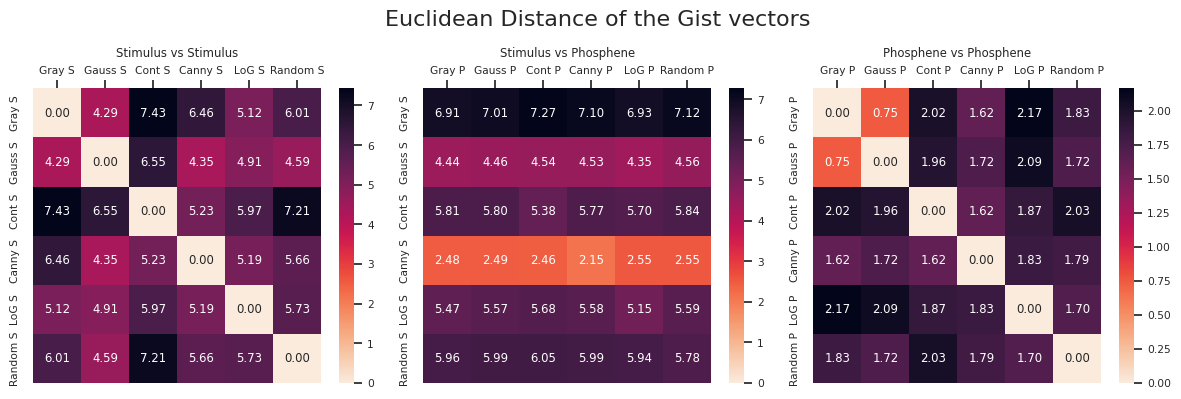

In [22]:
# 1. Stimulus vs Stimulus (symmetric)
stim_stim_matrix = np.zeros(((len(stim_gist_vectors)), len(stim_gist_vectors)))
for i in range(len(stim_gist_vectors)):
    for j in range(i, len(stim_gist_vectors)):
        swd_val = euclidean(stim_gist_vectors[i], stim_gist_vectors[j])
        stim_stim_matrix[i, j] = swd_val
        stim_stim_matrix[j, i] = swd_val

# 2. Stim vs Phosphene
stim_phos_matrix = np.zeros(((len(stim_gist_vectors)), len(phos_gist_vectors)))
for i in range(len(stim_gist_vectors)):
    for j in range(len(phos_gist_vectors)):
        swd_val = euclidean(stim_gist_vectors[i], phos_gist_vectors[j])
        stim_phos_matrix[i, j] = swd_val

# 3. Phos vs Phos (symmetric)
phos_phos_matrix = np.zeros(((len(phos_gist_vectors)), len(phos_gist_vectors)))
for i in range(len(phos_gist_vectors)):
    for j in range(i, len(phos_gist_vectors)):
        swd_val = euclidean(phos_gist_vectors[i], phos_gist_vectors[j])
        phos_phos_matrix[i, j] = swd_val
        phos_phos_matrix[j, i] = swd_val
                            
# Now plot three separate heatmaps.
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.set(font_scale=0.7)

# Plot Stimulus vs Stimulus heatmap
sns.heatmap(stim_stim_matrix, annot=True, fmt=".2f",
            xticklabels=labels_stim, yticklabels=labels_stim, ax=axes[0], cmap='rocket_r', vmin=0)
axes[0].set_title("Stimulus vs Stimulus")
axes[0].xaxis.tick_top()

# Plot Stimulus vs Phosphene heatmap (full matrix)
sns.heatmap(stim_phos_matrix, annot=True, fmt=".2f",
            xticklabels=labels_phos, yticklabels=labels_stim, ax=axes[1], cmap='rocket_r', vmin=0)
axes[1].set_title("Stimulus vs Phosphene")
axes[1].xaxis.tick_top()

# Plot Phosphene vs Phosphene heatmap
sns.heatmap(phos_phos_matrix, annot=True, fmt=".2f",
            xticklabels=labels_phos, yticklabels=labels_phos, ax=axes[2], cmap='rocket_r', vmin=0)
axes[2].set_title("Phosphene vs Phosphene")
axes[2].xaxis.tick_top()

plt.suptitle("Euclidean Distance of the Gist vectors", size=16)

plt.tight_layout()
plt.show()

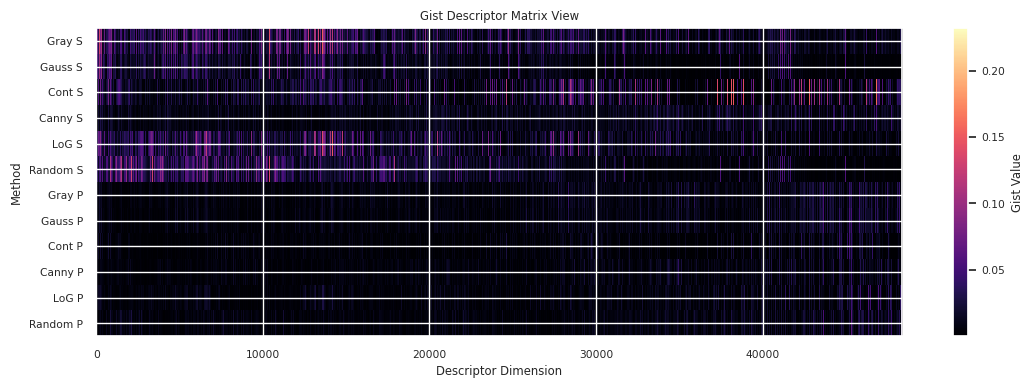

In [23]:
# stim_gist_vectors and phos_gist_vectors are the gist vectors for the stimuli and phosphenes, respectively.

gist_matrix = torch.cat([stim_gist_vectors, phos_gist_vectors], dim=0).cpu().numpy()

# Define row labels for clarity
row_labels = labels_stim + labels_phos

# Create a figure to display the matrix as a heatmap.
plt.figure(figsize=(13, 4))
plt.imshow(gist_matrix, aspect='auto', cmap='magma', interpolation='None')
plt.colorbar(label='Gist Value')
plt.xlabel('Descriptor Dimension')
plt.ylabel('Method')
plt.yticks(
    ticks=np.arange(gist_matrix.shape[0]),
    labels=row_labels,
)
plt.title('Gist Descriptor Matrix View')
plt.show()

### Feature Similarity Index Measure (FSIM) 

In [24]:
def compute_symmetric_loss_matrix(loss_fn, vec_list):
    """
    Compute a symmetric loss matrix for a list of vectors.
    
    Args:
      loss_fn: A callable loss function that takes two torch tensors and returns a scalar tensor.
      vec_list: A list of torch tensors.
      
    Returns:
      mat: A numpy array of shape (n, n) where n = len(vec_list)
    """
    n = len(vec_list)
    mat = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            loss_val = loss_fn(vec_list[i], vec_list[j]).item()  # Assume loss_fn returns a tensor
            mat[i, j] = loss_val
            mat[j, i] = loss_val
    return mat

def compute_nonsymmetric_loss_matrix(loss_fn, vec_list1, vec_list2):
    """
    Compute a non-symmetric loss matrix between two lists of vectors.
    
    Args:
      loss_fn: A callable loss function.
      vec_list1: List of torch tensors (e.g. stimulus vectors).
      vec_list2: List of torch tensors (e.g. phosphene vectors).
      
    Returns:
      mat: A numpy array of shape (n1, n2).
    """
    n1 = len(vec_list1)
    n2 = len(vec_list2)
    mat = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            loss_val = loss_fn(vec_list1[i], vec_list2[j]).item()
            mat[i, j] = loss_val
    return mat

def evaluate_loss_matrices(image_processing_dict, image_index, loss_fn):
    """
    Extracts stimulus and phosphene images from image_processing_dict for a given image index,
    computes the loss matrices using the provided loss function, and returns three matrices:
    - Stimulus vs. Stimulus (symmetric)
    - Stimulus vs. Phosphene (non-symmetric: rows=stim, cols=phos)
    - Phosphene vs. Phosphene (symmetric)
    
    The images are assumed to be stored as:
      image_processing_dict[image_index]['grayscale']['stim']
      image_processing_dict[image_index]['contour']['stim']
      image_processing_dict[image_index]['LoG_response']['stim']  (using .max(0).values)
      
      image_processing_dict[image_index]['grayscale']['phosphenes']
      image_processing_dict[image_index]['contour']['phosphenes']
      image_processing_dict[image_index]['LoG_response']['phosphenes']
    
    Returns:
      stim_stim_matrix, stim_phos_matrix, phos_phos_matrix as numpy arrays.
    """
    
    stim_vectors = [image_processing_dict[image_index][key]['stim'] for key in image_processing_dict[image_index].keys() if key != 'image']
    phos_vectors = [image_processing_dict[image_index][key]['phosphenes'] for key in image_processing_dict[image_index].keys() if key != 'image']

    stim_stim_matrix = compute_symmetric_loss_matrix(loss_fn, stim_vectors)
    stim_phos_matrix = compute_nonsymmetric_loss_matrix(loss_fn, stim_vectors, phos_vectors)
    phos_phos_matrix = compute_symmetric_loss_matrix(loss_fn, phos_vectors)
    
    return stim_stim_matrix, stim_phos_matrix, phos_phos_matrix

def plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title=None):
    """
    Plot three heatmaps showing the loss matrices for:
      1. Stimulus vs. Stimulus (symmetric)
      2. Stimulus vs. Phosphene (non-symmetric)
      3. Phosphene vs. Phosphene (symmetric)
    """
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    sns.heatmap(stim_stim_matrix, annot=True, fmt=".2f",
                xticklabels=labels_stim, yticklabels=labels_stim, ax=axes[0], cmap='rocket_r', vmin=0)
    axes[0].set_title("Stimulus vs Stimulus")
    axes[0].xaxis.tick_top()

    sns.heatmap(stim_phos_matrix, annot=True, fmt=".2f",
                xticklabels=labels_phos, yticklabels=labels_stim, ax=axes[1], cmap='rocket_r', vmin=0)
    axes[1].set_title("Stimulus vs Phosphene")
    axes[1].xaxis.tick_top()

    sns.heatmap(phos_phos_matrix, annot=True, fmt=".2f",
                xticklabels=labels_phos, yticklabels=labels_phos, ax=axes[2], cmap='rocket_r', vmin=0)
    axes[2].set_title("Phosphene vs Phosphene")
    axes[2].xaxis.tick_top()

    if title:
        plt.suptitle(title, size=16)

    plt.tight_layout()
    plt.show()

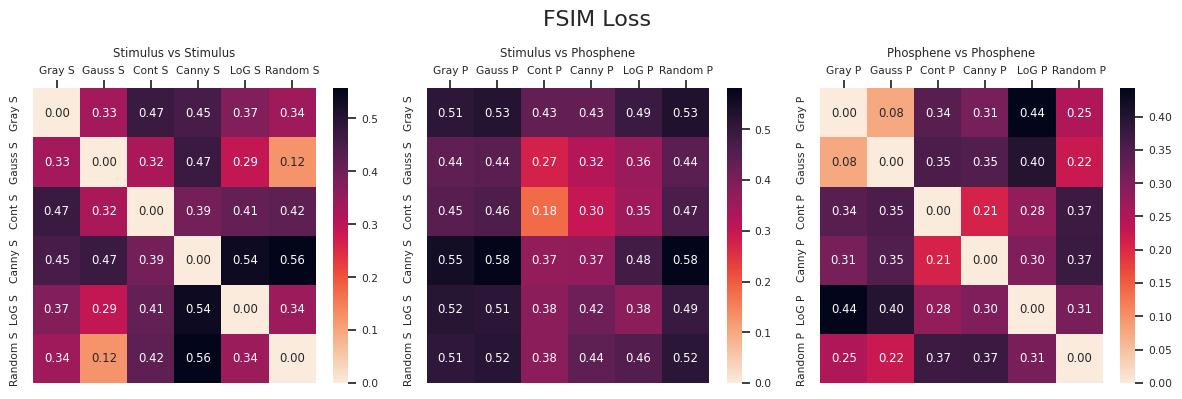

In [25]:
import piq
torch.use_deterministic_algorithms(False)

image_index = 5

fsim_loss = piq.FSIMLoss(chromatic=False, min_length=7, scales=4).cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, image_index, fsim_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='FSIM Loss')

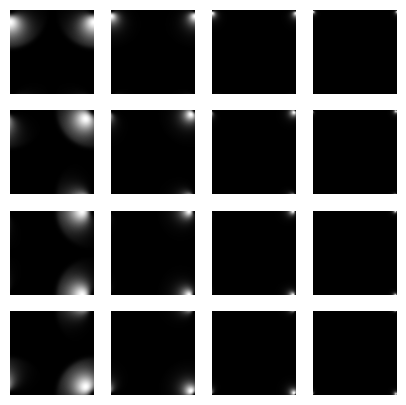

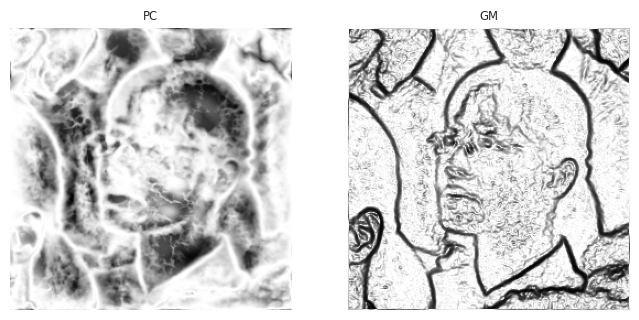

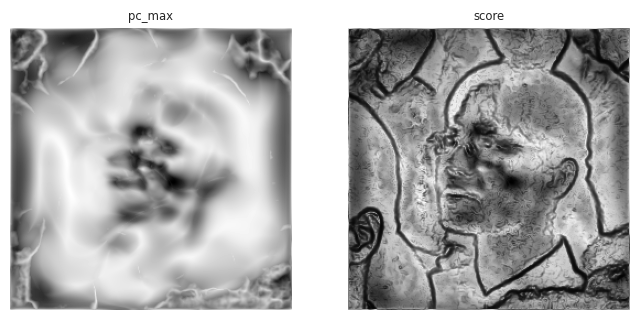

In [26]:
grayscale_image = image_processing_dict[image_index]['grayscale']['stim'].detach()
gaussian_image = image_processing_dict[image_index]['grayscale_gauss']['stim'].detach()
data = fsim_loss.data(grayscale_image, gaussian_image)

# data = {'filters': filters, 'PC': PC, 'GM': GM, 'pc_max': pc_max, 'score': score}
# subplot of filters 4 x 4
plt.figure(figsize=(5, 5))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(data['filters'][0][i].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

# plot PC and GM
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(data['PC'][0,0].cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('PC')

plt.subplot(1, 2, 2)
plt.imshow(data['GM'][0,0].cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('GM')
plt.show()

# plot pc_max and score
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(data['pc_max'][0,0].cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('pc_max')

plt.subplot(1, 2, 2)
plt.imshow(data['score'][0,0].cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('score')
plt.show()

### Learned Perceptual Image Patch Similarity (LPIPS)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


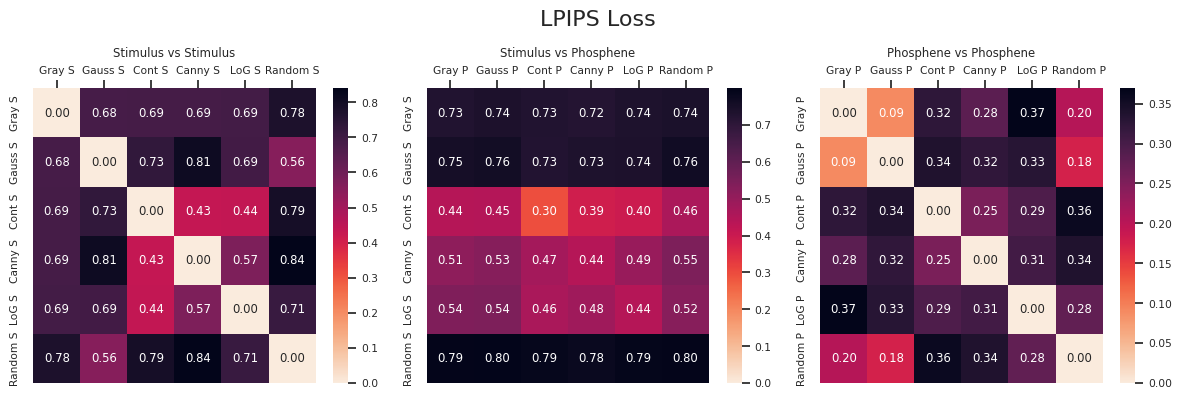

In [27]:
LPIPS_loss = piq.LPIPS()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, image_index, LPIPS_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='LPIPS Loss')

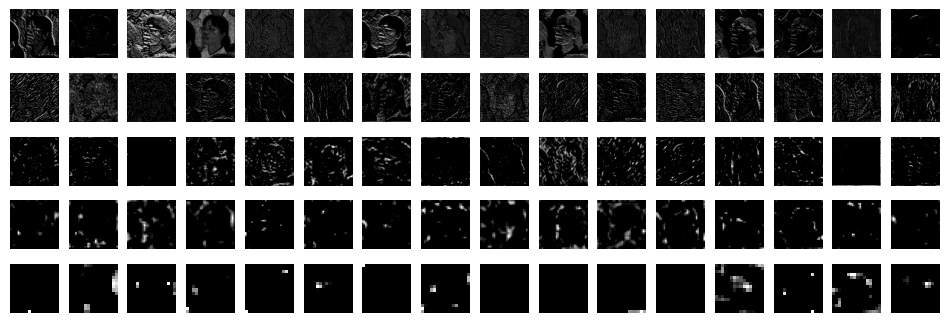

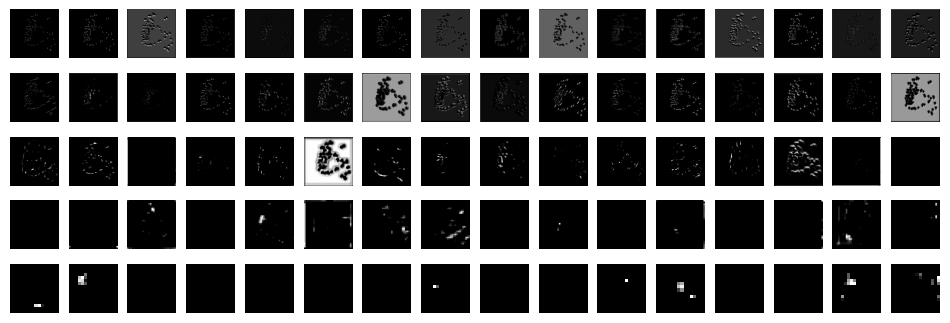

In [28]:
features = LPIPS_loss.get_features(grayscale_image)
plt.figure(figsize=(12, 4))
for i in range(5):
    # plt.figure(figsize=(15, 5))
    n_images = len(features[i][0])
    max = 16
    if n_images > max:
        n_images = max
    for j in range(n_images):
        plt.subplot(5, n_images, i*n_images+j+1)
        plt.imshow(features[i][0][j].cpu().detach().numpy(), cmap='gray')
        plt.axis('off')
plt.show()

contour_phosphenes = image_processing_dict[image_index]['contour']['phosphenes']
features_phosphene = LPIPS_loss.get_features(contour_phosphenes)
plt.figure(figsize=(12, 4))
for i in range(5):
    n_images = len(features_phosphene[i][0])
    max = 16
    if n_images > max:
        n_images = max

    for j in range(n_images): 
        plt.subplot(5, n_images, i*n_images+j+1)
        plt.imshow(features_phosphene[i][0][j].cpu().detach().numpy(), cmap='gray')
        plt.axis('off')
plt.show()

### Perceptual Image-Error Assessment through Pairwise Preference(PieAPP)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/pieapp.py:171: UserWarning: The original PieAPP supports only RGB images.The input images were converted to RGB by copying the grey channel 3 times.
  warnings.warn('The original PieAPP supports only RGB images.'


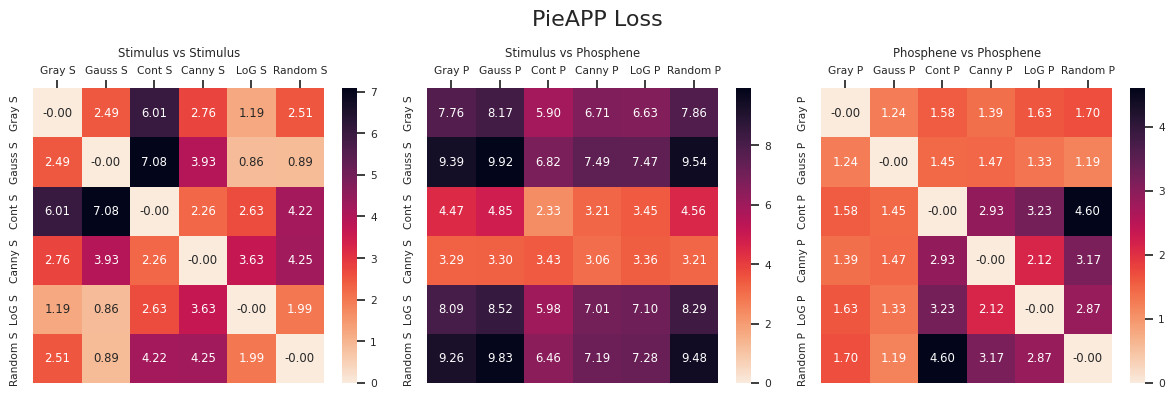

In [29]:
pieapp_loss = piq.PieAPP()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, image_index, pieapp_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='PieAPP Loss')

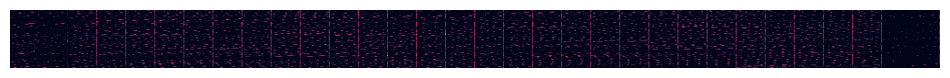

torch.Size([64, 120832])


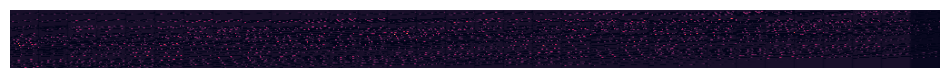

In [30]:
# make "RGB" image by stacking the grayscale image 3 times
grayscale_image_rgb = torch.cat([grayscale_image]*3, dim=1)
features = pieapp_loss.get_features(grayscale_image_rgb)
plt.figure(figsize=(12, 2))
plt.imshow(features[0].cpu()[:, 1024:2048])
plt.axis('off')
plt.show()

grayscale_log_phosphenes = image_processing_dict[image_index]['LoG_response']['phosphenes']
grayscale_log_phosphenes_rgb = torch.cat([grayscale_log_phosphenes]*3, dim=1)
features = pieapp_loss.get_features(grayscale_log_phosphenes_rgb)
print(features[0].shape)
plt.figure(figsize=(12, 2))
plt.imshow(features[0].cpu()[:, 1024:2048])
plt.axis('off')
plt.show()

### Deep Image Structure and Texture Similarity(DISTS)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


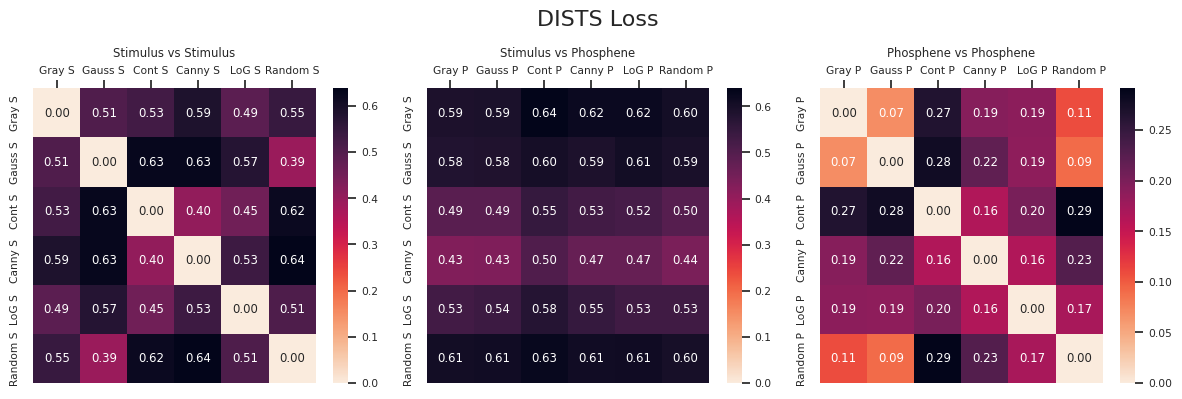

In [31]:
dists_loss = piq.DISTS()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, image_index, dists_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='DISTS Loss')

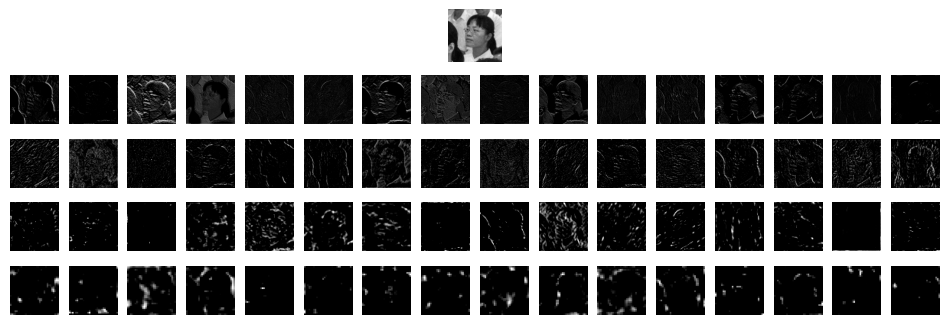

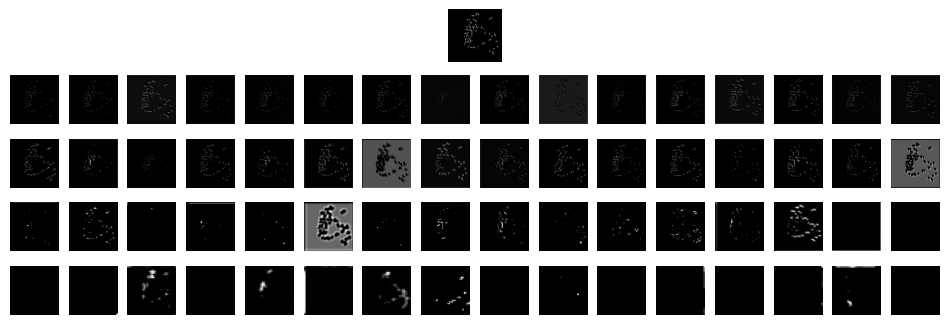

In [32]:
features = dists_loss.get_features(grayscale_image)
plt.figure(figsize=(12, 4))
for i in range(5):
    n_images = len(features[i][0])
    max = 16
    if n_images > max:
        n_images = max

    for j in range(n_images):
        plt.subplot(5, n_images, i*n_images+j+1)
        plt.imshow(features[i][0][j].cpu().detach().numpy(), cmap='gray')
        plt.axis('off')
plt.show()

contour_phosphenes = image_processing_dict[image_index]['contour']['phosphenes']
features_phosphene = dists_loss.get_features(contour_phosphenes)
plt.figure(figsize=(12, 4))
for i in range(5):
    n_images = len(features_phosphene[i][0])
    max = 16
    if n_images > max:
        n_images = max

    for j in range(n_images):
        plt.subplot(5, n_images, i*n_images+j+1)
        plt.imshow(features_phosphene[i][0][j].cpu().detach().numpy(), cmap='gray')
        plt.axis('off') 
plt.show()

### Content Loss

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


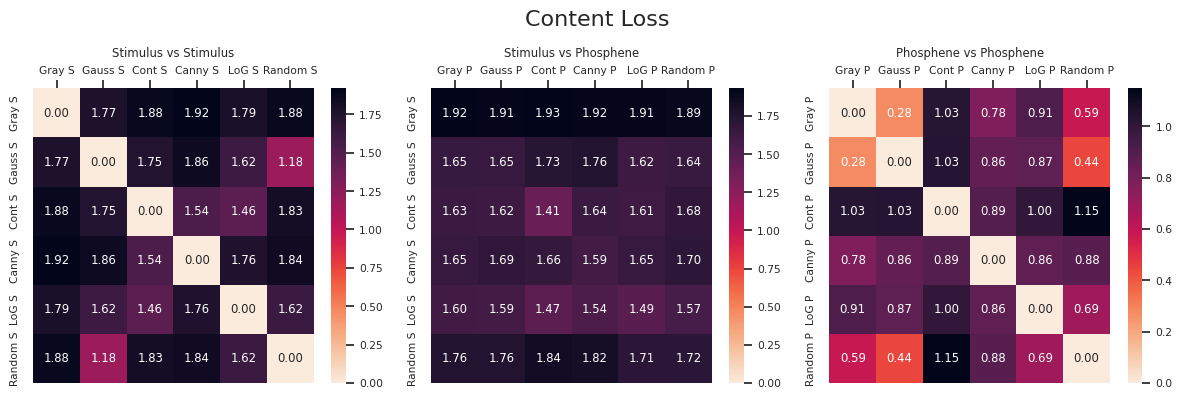

In [33]:
contentloss = piq.ContentLoss(feature_extractor='vgg19', normalize_features=True, layers=['relu5_4'])

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, image_index, contentloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='Content Loss')

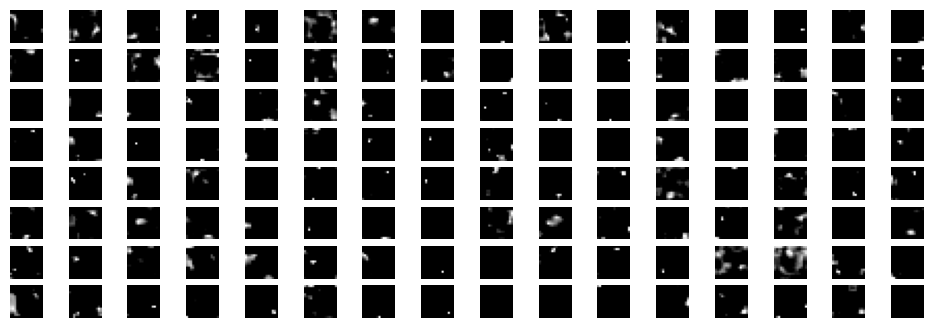

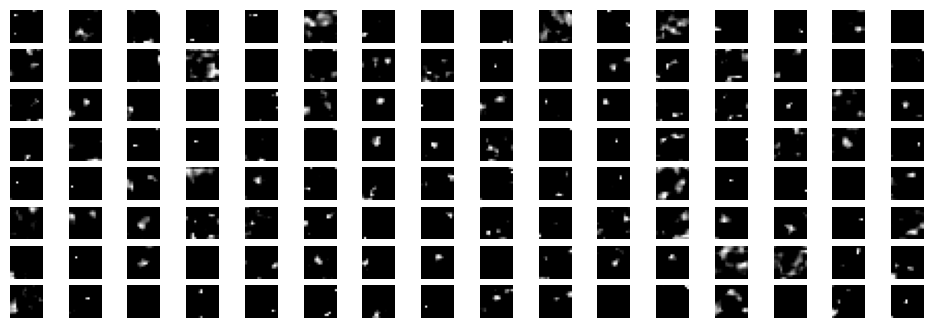

In [34]:
features = contentloss.get_features(image_processing_dict[image_index]['grayscale']['stim'].cuda())[0]

# 256 feature maps: 16 x 16 plot
plt.figure(figsize=(12, 4))
for i in range(128):
    plt.subplot(8, 16, i+1)
    plt.imshow(features[0, i].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

features_inv = contentloss.get_features(1-image_processing_dict[image_index]['grayscale']['stim'].cuda())[0]

# 256 feature maps: 16 x 16 plot
plt.figure(figsize=(12, 4))
for i in range(128):
    plt.subplot(8, 16, i+1)
    plt.imshow(features_inv[0, i].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

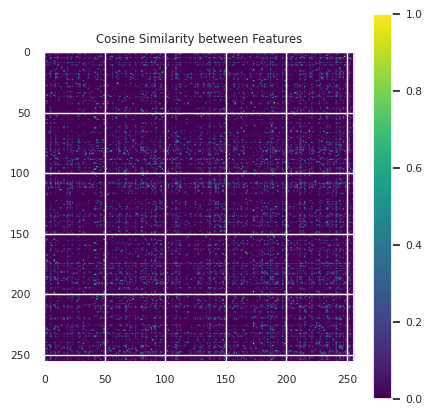

In [35]:
# Correlation between features
correlation = torch.zeros(256, 256)
for i in range(256):
    for j in range(256):
        correlation[i, j] = torch.nn.functional.cosine_similarity(features[0, i].flatten(), features_inv[0, j].flatten(), dim=0)

plt.figure(figsize=(5, 5))
plt.imshow(correlation.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('Cosine Similarity between Features')
plt.show()

### Strucural Similarity (SSIM)

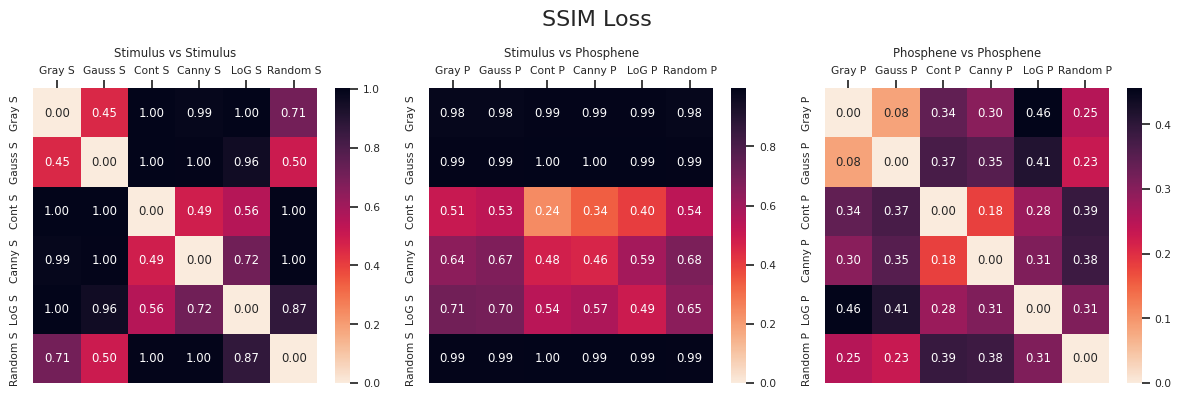

In [36]:
ssim_loss = piq.SSIMLoss()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, image_index, ssim_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='SSIM Loss')

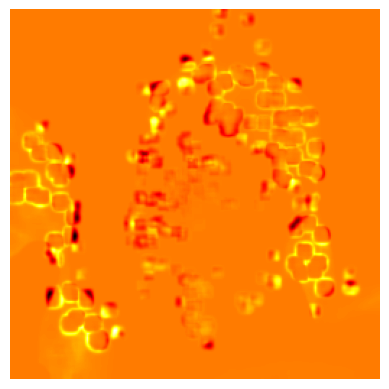

In [37]:
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# Compute SSIM and get the full SSIM map
# original_img and processed_img are numpy arrays, e.g. in the range [0, 1]
log_phosphene = image_processing_dict[image_index]['LoG_response']['phosphenes']
_, ssim_map = ssim(grayscale.cpu().numpy()[0,0], log_phosphene.cpu().numpy()[0,0], full=True, data_range=1.0)
plt.imshow(ssim_map, cmap='hot')
plt.axis('off')
plt.show()

### Multi-Scale Structural Similarity (MS-SSIM)

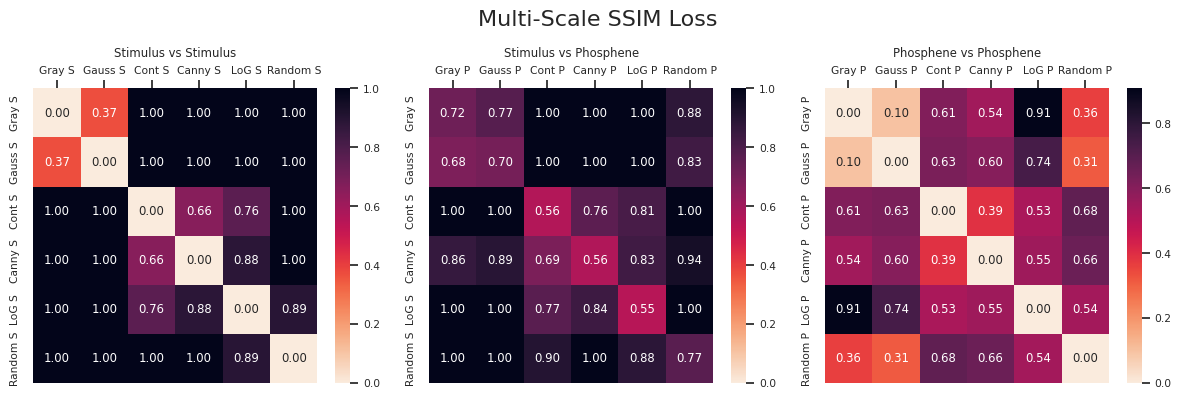

In [38]:
msssim_loss = piq.MultiScaleSSIMLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, image_index, msssim_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='Multi-Scale SSIM Loss')

### Information Content Weighted Structural Similarity (IW-SSIM)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/iw_ssim.py:256: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  lo_x = F.conv2d(input=lo_x, weight=kernel_t.unsqueeze(0), padding=0)[:, :, ::2, :]
/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/iw_ssim.py:272: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  hi_x = F.conv2d(input=hi_x, weight=kernel_t.unsqueeze(0), padding=0)[:, :, :x.size(-2), :]
/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/iw_ssim.py:253: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descripto

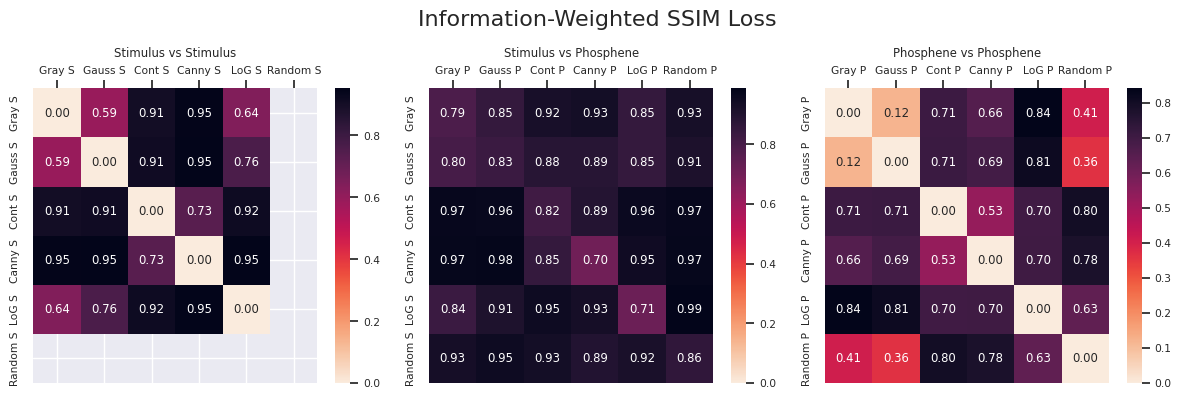

In [39]:
iwssim_loss = piq.InformationWeightedSSIMLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, image_index, iwssim_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='Information-Weighted SSIM Loss')

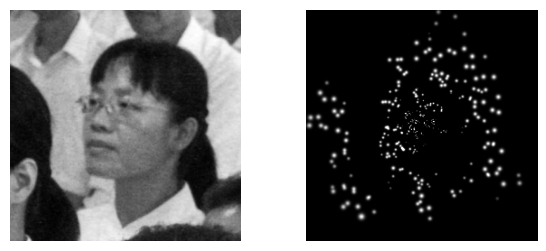

Score: 0.1507047861814499


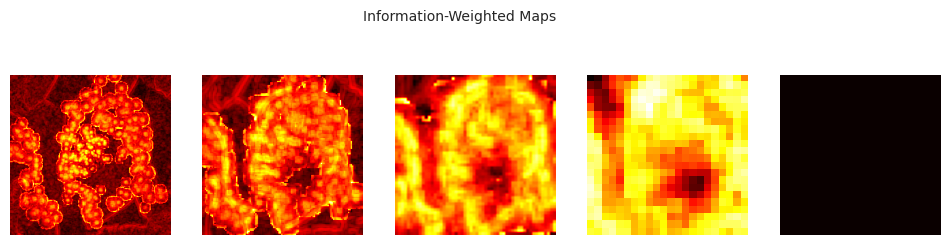

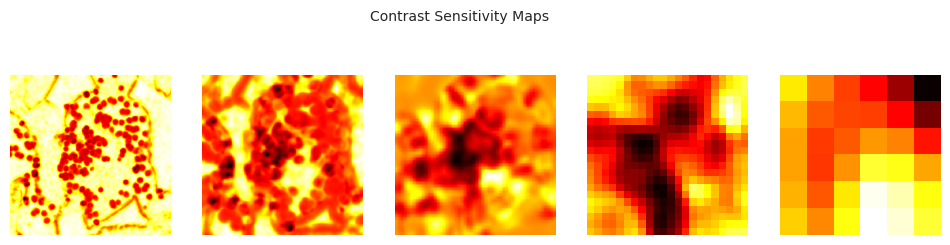

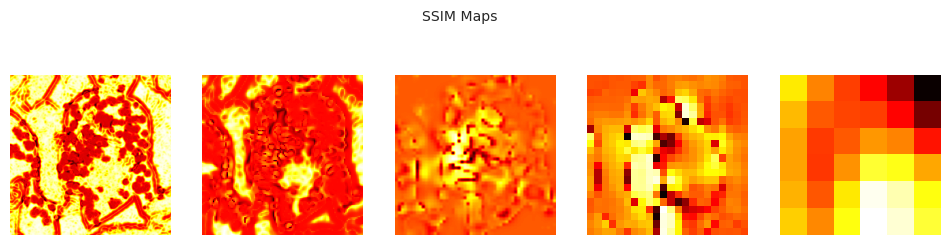

In [40]:
iwssim_loss = piq.InformationWeightedSSIMLoss(return_maps=True).cuda()

im1 = grayscale
im2 = LoG_phosphenes

plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.imshow(im1.cpu().detach().numpy()[0,0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(im2.cpu().detach().numpy()[0,0], cmap='gray')
plt.axis('off')
plt.show()

maps = iwssim_loss(im1, im2)

print(f"Score: {maps['score'].item()}")

plt.figure(figsize=(12, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(maps['iw_map'][i].cpu().detach().numpy()[0,0], cmap='hot')
    plt.axis('off')
plt.suptitle('Information-Weighted Maps')
plt.show()

plt.figure(figsize=(12, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(maps['cs_map'][i].cpu().detach().numpy()[0,0], cmap='hot')
    plt.axis('off')
plt.suptitle('Contrast Sensitivity Maps')
plt.show()

plt.figure(figsize=(12, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(maps['ssim_map'][i].cpu().detach().numpy()[0,0], cmap='hot')
    plt.axis('off')
plt.suptitle('SSIM Maps')
plt.show()

### Visual Information Fidelity (VIFp)

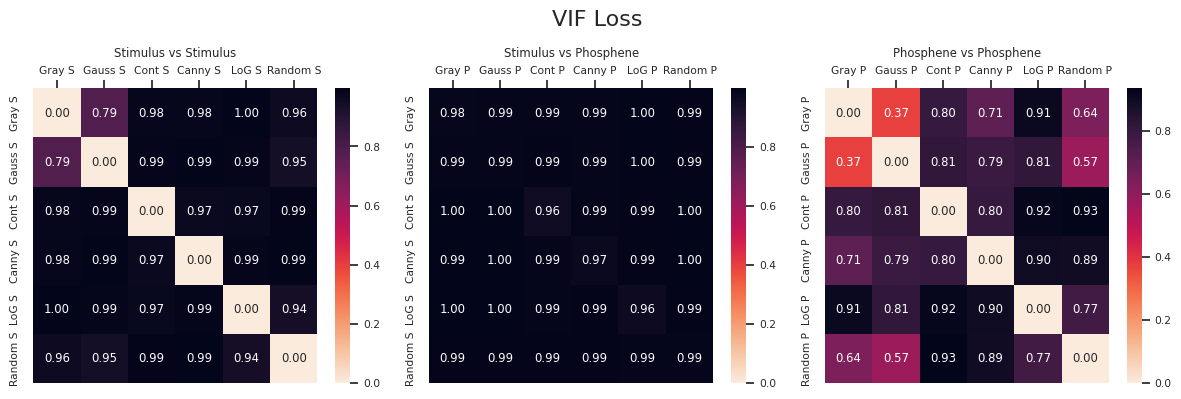

In [41]:
vifloss = piq.VIFLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, image_index, vifloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='VIF Loss')

### Spectral Residual based Similarity Measure (SR-SIM)

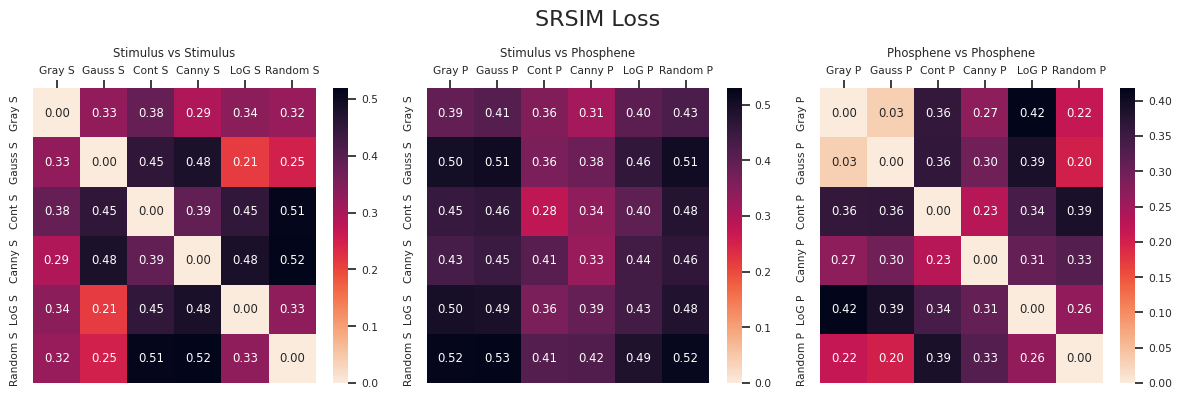

In [42]:
srsimloss = piq.SRSIMLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, image_index, srsimloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='SRSIM Loss')

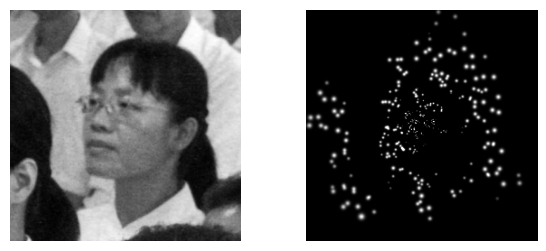

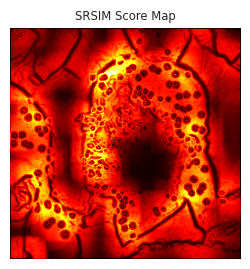

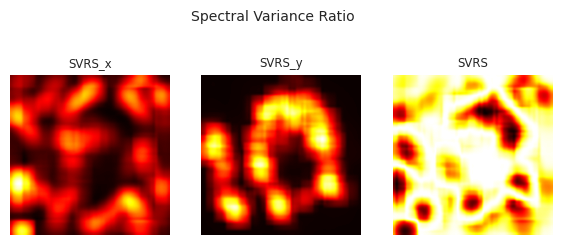

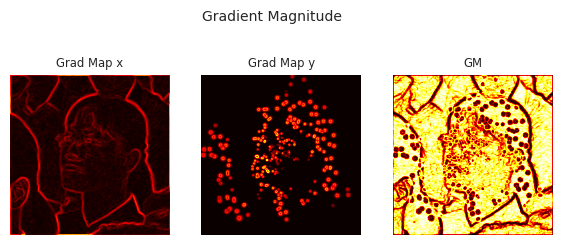

In [43]:
srsimloss_maps = piq.SRSIMLoss(return_maps=True).cuda()

im1 = grayscale
im2 = LoG_phosphenes

# show im1 and im2
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.imshow(im1.cpu().detach().numpy().squeeze(0).squeeze(0), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(im2.cpu().detach().numpy().squeeze(0).squeeze(0), cmap='gray')
plt.axis('off')
plt.show()

maps = srsimloss_maps(im1, im2)
# print(maps.keys()) dict_keys(['svrs_x', 'svrs_y', 'grad_map_x', 'grad_map_y', 'SVRS', 'GM', 'score', 'result'])

plt.figure(figsize=(3, 3))
plt.imshow(maps['score'].cpu().detach().numpy().squeeze(0).squeeze(0), cmap='hot')
plt.axis('off')
plt.title('SRSIM Score Map')
plt.show()

plt.figure(figsize=(7, 3))
plt.subplot(1, 3, 1)
plt.imshow(maps['svrs_x'].cpu().detach().numpy().squeeze(0).squeeze(0), cmap='hot')
plt.axis('off')
plt.title('SVRS_x')

plt.subplot(1, 3, 2)
plt.imshow(maps['svrs_y'].cpu().detach().numpy().squeeze(0).squeeze(0), cmap='hot')
plt.axis('off')
plt.title('SVRS_y')

plt.subplot(1, 3, 3)
plt.imshow(maps['SVRS'].cpu().detach().numpy().squeeze(0).squeeze(0), cmap='hot')
plt.axis('off')
plt.title('SVRS')
plt.suptitle('Spectral Variance Ratio')
plt.show()

plt.figure(figsize=(7, 3))
plt.subplot(1, 3, 1)
plt.imshow(maps['grad_map_x'].cpu().detach().numpy().squeeze(0).squeeze(0), cmap='hot')
plt.axis('off')
plt.title('Grad Map x')

plt.subplot(1, 3, 2)
plt.imshow(maps['grad_map_y'].cpu().detach().numpy().squeeze(0).squeeze(0), cmap='hot')
plt.axis('off')
plt.title('Grad Map y')

plt.subplot(1, 3, 3)
plt.imshow(maps['GM'].cpu().detach().numpy().squeeze(0).squeeze(0), cmap='hot')
plt.axis('off')
plt.title('GM')
plt.suptitle('Gradient Magnitude')
plt.show()

### Gradient Magnitude Similarity Deviation (GMSD)

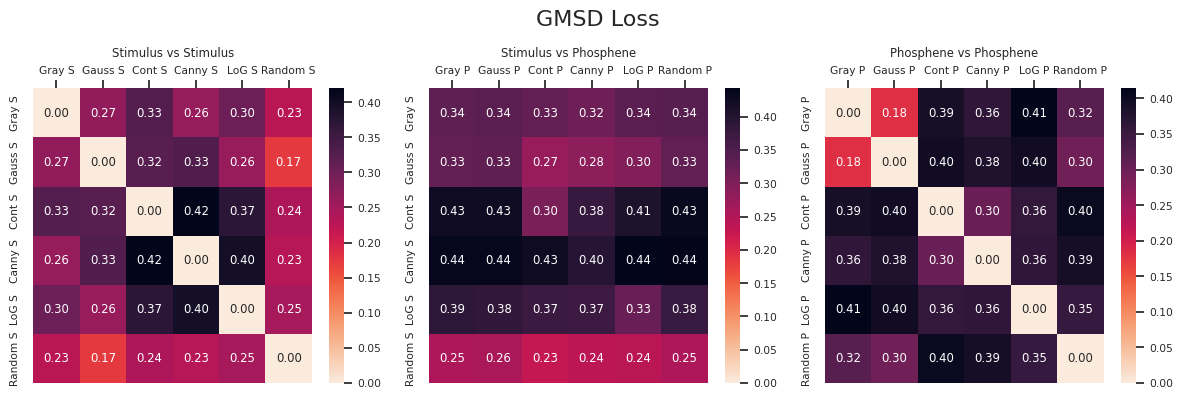

In [44]:
loss = piq.GMSDLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, image_index, loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='GMSD Loss')

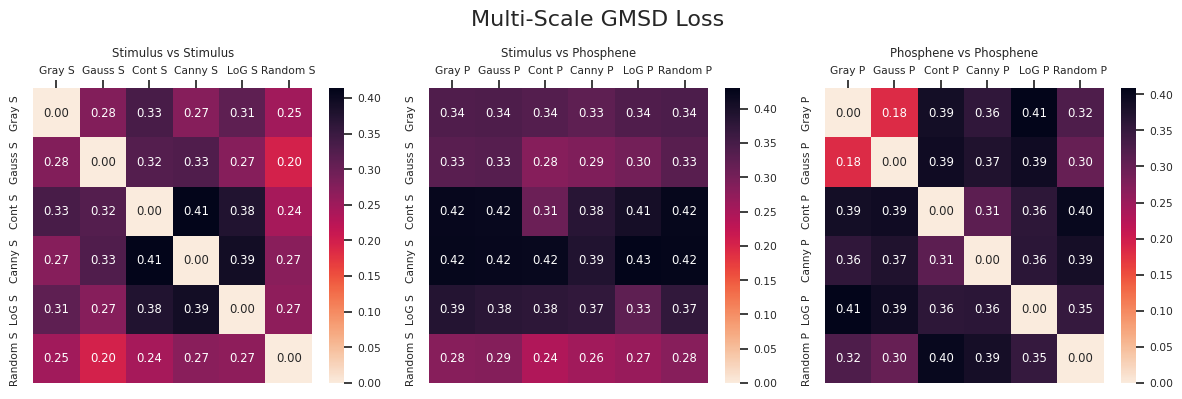

In [45]:
loss = piq.MultiScaleGMSDLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, image_index, loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='Multi-Scale GMSD Loss')

### Visual Saliency-induced Index (VSI)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/vsi.py:63: UserWarning: The original VSI supports only RGB images. The input images were converted to RGB by copying the grey channel 3 times.
  warnings.warn('The original VSI supports only RGB images. The input images were converted to RGB by copying '


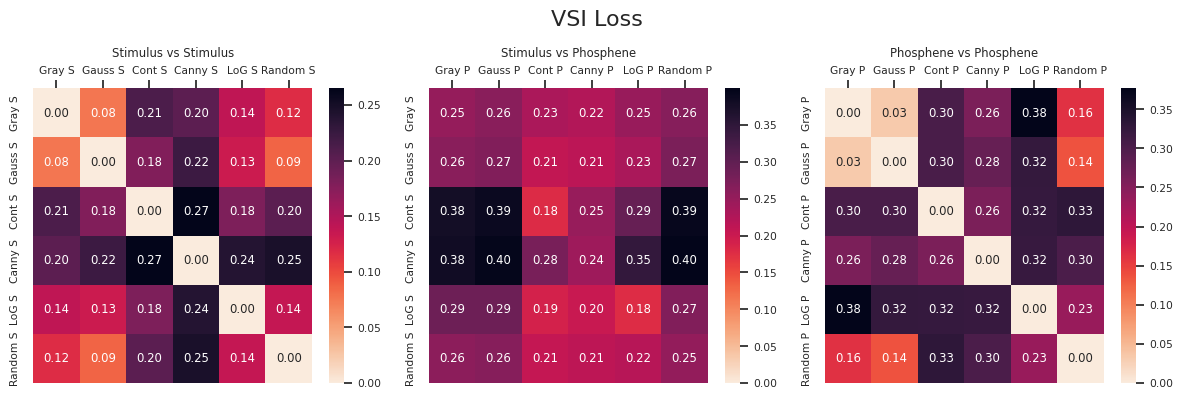

In [46]:
vsiloss = piq.VSILoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, image_index, vsiloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='VSI Loss')

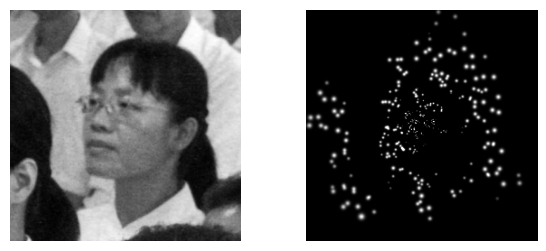

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/vsi.py:63: UserWarning: The original VSI supports only RGB images. The input images were converted to RGB by copying the grey channel 3 times.
  warnings.warn('The original VSI supports only RGB images. The input images were converted to RGB by copying '


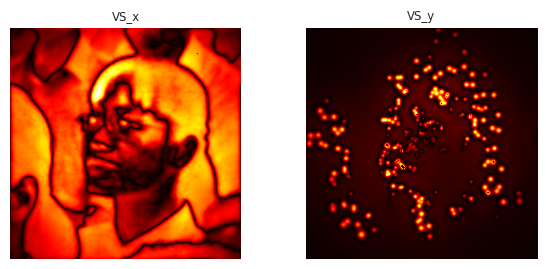

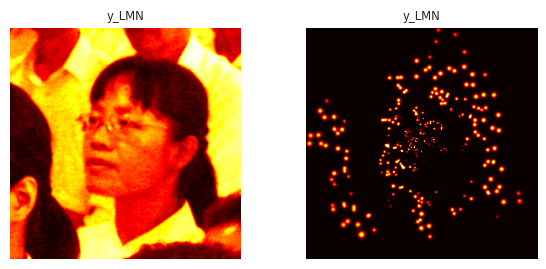

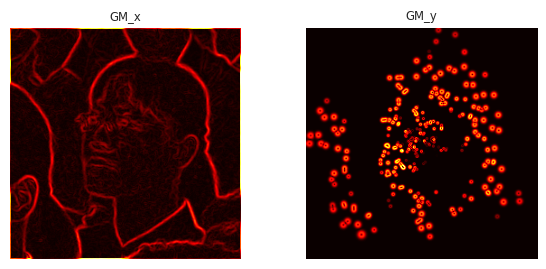

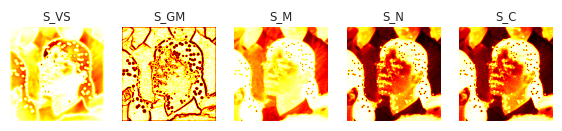

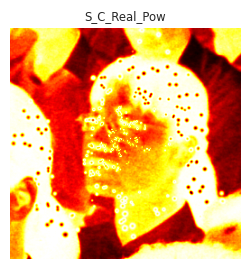

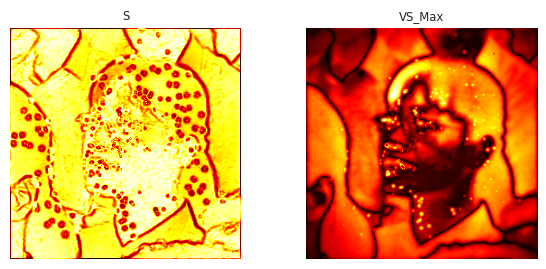

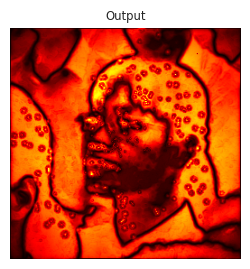

In [47]:
vsiloss_maps = piq.VSILoss(return_maps=True).cuda()

im1 = grayscale
im2 = LoG_phosphenes

# show im1 and im2
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.imshow(im1.cpu().detach().numpy().squeeze(0).squeeze(0), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(im2.cpu().detach().numpy().squeeze(0).squeeze(0), cmap='gray')
plt.axis('off')
plt.show()

maps = vsiloss_maps(im1, im2)

# show all maps, starting with vs_x and vs_y
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.imshow(maps['vs_x'].cpu().detach().numpy().squeeze(0).squeeze(0), cmap='hot')
plt.axis('off')
plt.title('VS_x')

plt.subplot(1, 2, 2)
plt.imshow(maps['vs_y'].cpu().detach().numpy().squeeze(0).squeeze(0), cmap='hot')
plt.axis('off')
plt.title('VS_y')
plt.show()

# show x_lmn and y_lmn
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.imshow(maps['x_lmn'].mean(1).squeeze(0).cpu(), cmap='hot')
plt.axis('off')
plt.title('y_LMN')

plt.subplot(1, 2, 2)
plt.imshow(maps['y_lmn'].mean(1).squeeze(0).cpu(), cmap='hot')
plt.axis('off')
plt.title('y_LMN')
plt.show()

# show gm_x and gm_y
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.imshow(maps['gm_x'].cpu().detach().numpy().squeeze(0).squeeze(0), cmap='hot')
plt.axis('off')
plt.title('GM_x')

plt.subplot(1, 2, 2)
plt.imshow(maps['gm_y'].cpu().detach().numpy().squeeze(0).squeeze(0), cmap='hot')
plt.axis('off')
plt.title('GM_y')
plt.show()

plt.figure(figsize=(7, 3))
plt.subplot(1, 5, 1)
plt.imshow(maps['s_vs'].cpu().detach().numpy().squeeze(0).squeeze(0), cmap='hot')
plt.axis('off')
plt.title('S_VS')

plt.subplot(1, 5, 2)
plt.imshow(maps['s_gm'].cpu().detach().numpy().squeeze(0).squeeze(0), cmap='hot')
plt.axis('off')
plt.title('S_GM')

plt.subplot(1, 5, 3)
plt.imshow(maps['s_m'].cpu().detach().numpy().squeeze(0).squeeze(0), cmap='hot')
plt.axis('off')
plt.title('S_M')

plt.subplot(1, 5, 4)
plt.imshow(maps['s_n'].cpu().detach().numpy().squeeze(0).squeeze(0), cmap='hot')
plt.axis('off')
plt.title('S_N')

plt.subplot(1, 5, 5)
plt.imshow(maps['s_c'].cpu().detach().numpy().squeeze(0).squeeze(0), cmap='hot')
plt.axis('off')
plt.title('S_C')
plt.show()

plt.figure(figsize=(7, 3))
plt.imshow(maps['s_c_real_pow'].cpu().detach().numpy().squeeze(0).squeeze(0), cmap='hot')
plt.axis('off')
plt.title('S_C_Real_Pow')
plt.show()

plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.imshow(maps['s'].cpu().detach().numpy().squeeze(0).squeeze(0), cmap='hot')
plt.axis('off')
plt.title('S')

plt.subplot(1, 2, 2)
plt.imshow(maps['vs_max'].cpu().detach().numpy().squeeze(0).squeeze(0), cmap='hot')
plt.axis('off')
plt.title('VS_Max')
plt.show()

plt.figure(figsize=(7, 3))
plt.imshow(maps['output'].cpu().detach().numpy().squeeze(0).squeeze(0), cmap='hot')
plt.axis('off')
plt.title('Output')
plt.show()


### DCT Subband Similarity Index (DSS)

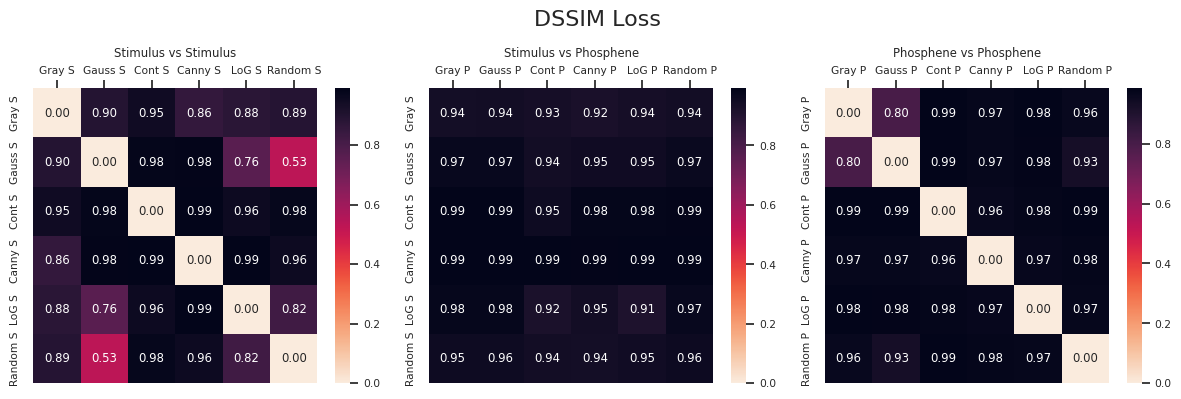

In [48]:
dssloss = piq.DSSLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, image_index, dssloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='DSSIM Loss')

### Haar Perceptual Similarity Index (HaarPSI)

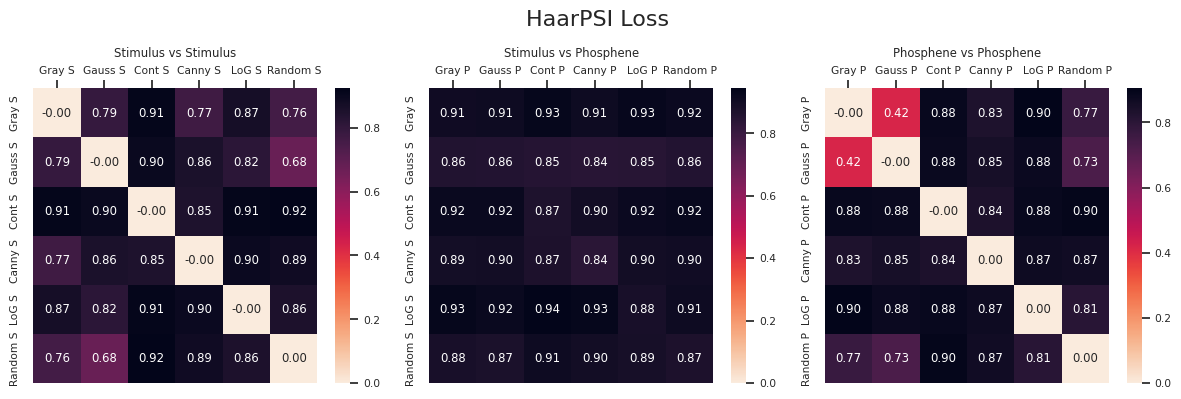

In [49]:
haarloss = piq.HaarPSILoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, image_index, haarloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='HaarPSI Loss')

### Mean Deviation Similarity Index (MDSI)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/mdsi.py:66: UserWarning: The original MDSI supports only RGB images. The input images were converted to RGB by copying the grey channel 3 times.
  warnings.warn('The original MDSI supports only RGB images. The input images were converted to RGB by copying '


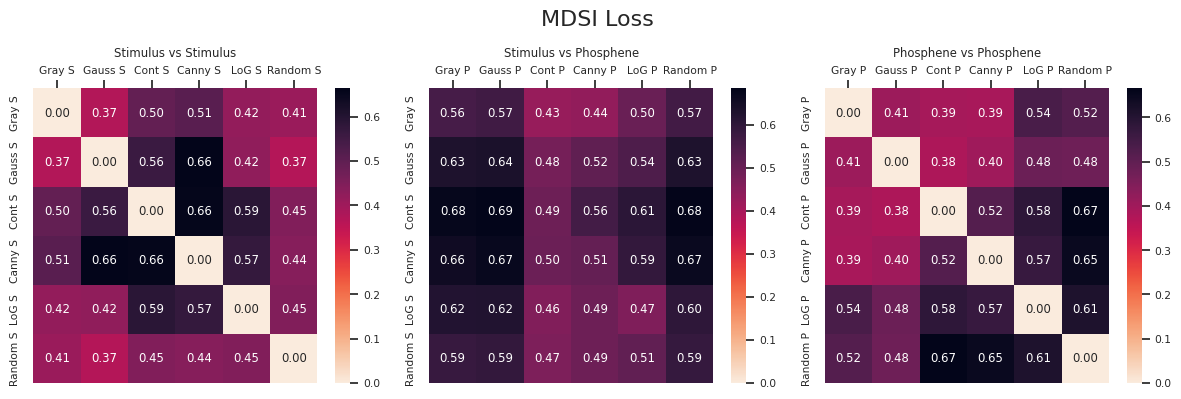

In [50]:
mdsiloss = piq.MDSILoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, image_index, mdsiloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='MDSI Loss')

### Fourier

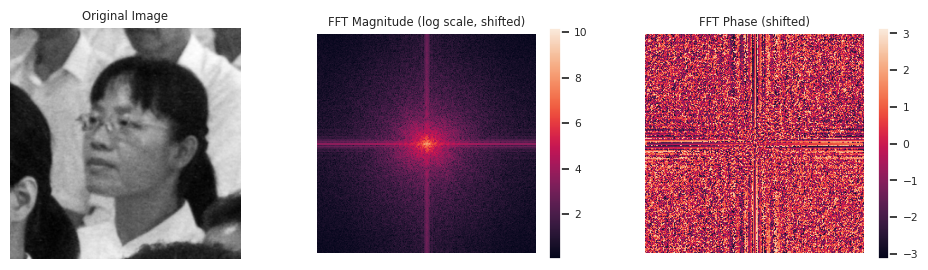

In [51]:
stim = grayscale
phos = LoG_phosphenes

fft_img = torch.fft.fft2(stim)

# fft_img is complex64 or complex128
magnitude = torch.abs(fft_img)  # amplitude
phase = torch.angle(fft_img)    # phase in radians

fft_img_shifted = torch.fft.fftshift(fft_img) # shift zero frequency component to center
magnitude_shifted = torch.abs(fft_img_shifted) # amplitude
phase_shifted = torch.angle(fft_img_shifted)   # phase in radians

magnitude_log = torch.log1p(magnitude_shifted) # log(1 + amplitude)

# Original image
original_img = stim.cpu()

# Shifted magnitude & phase
mag_for_viz = magnitude_log.cpu()
phase_for_viz = phase_shifted.cpu()

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].imshow(original_img[0,0], cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(mag_for_viz[0,0])
axs[1].set_title('FFT Magnitude (log scale, shifted)')
# colorbar
plt.colorbar(axs[1].imshow(mag_for_viz[0,0]), ax=axs[1])
axs[1].axis('off')

axs[2].imshow(phase_for_viz[0,0])
axs[2].set_title('FFT Phase (shifted)')
# colorbar
plt.colorbar(axs[2].imshow(phase_for_viz[0,0]), ax=axs[2])
axs[2].axis('off')

plt.show()

In [52]:
def compute_radial_power_spectrum_torch(image, nbins=100, fov=16.0):
    """
    Compute the radial power spectrum of a 2D image using PyTorch FFT,
    with frequencies expressed in cycles per degree.
    
    The image is assumed to be a 2D torch.Tensor of shape (H, W) (normalized, e.g., to [0,1]).
    The field of view (fov) is given in degrees, and the image is assumed to uniformly cover that FOV.
    
    Args:
        image (torch.Tensor): A 2D tensor of shape (H, W) containing the image.
        nbins (int): Number of radial bins.
        fov (float): Field of view in degrees.
    
    Returns:
        r_bins (torch.Tensor): 1D tensor of radial frequency bin centers (in cycles/degree).
        radial_profile (torch.Tensor): 1D tensor with the average power in each radial bin.
    """
    H, W = image.shape
    
    # Compute 2D FFT and shift the zero-frequency component to the center.
    F = torch.fft.fft2(image)
    F_shift = torch.fft.fftshift(F)
    power = torch.abs(F_shift) ** 2  # Power spectrum
    
    # Determine sample spacing in degrees.
    # If the image width is W and FOV is fov, then each pixel represents fov/W degrees.
    d = fov / W
    
    # Create frequency grids in cycles per degree.
    fx = torch.fft.fftfreq(W, d=d).to(image.device)
    fy = torch.fft.fftfreq(H, d=d).to(image.device)
    fx = torch.fft.fftshift(fx)
    fy = torch.fft.fftshift(fy)
    
    # Create meshgrid (with indexing='ij' so that output shape is (H, W)).
    FY, FX = torch.meshgrid(fy, fx, indexing='ij')
    R = torch.sqrt(FX**2 + FY**2)  # radial frequency in cycles per degree
    
    # Flatten the frequency grid and the power spectrum.
    R_flat = R.flatten()
    power_flat = power.flatten()
    
    # Define bin edges spanning the range of R.
    r_min = R_flat.min()
    r_max = R_flat.max()
    bin_edges = torch.linspace(r_min, r_max, nbins + 1, device=image.device)
    
    radial_profile = torch.zeros(nbins, device=image.device)
    r_bins = torch.zeros(nbins, device=image.device)
    
    for i in range(nbins):
        mask = (R_flat >= bin_edges[i]) & (R_flat < bin_edges[i+1])
        if mask.sum() > 0:
            radial_profile[i] = power_flat[mask].mean()
        else:
            radial_profile[i] = 0.0
        r_bins[i] = (bin_edges[i] + bin_edges[i+1]) / 2.0
        
    return r_bins, radial_profile

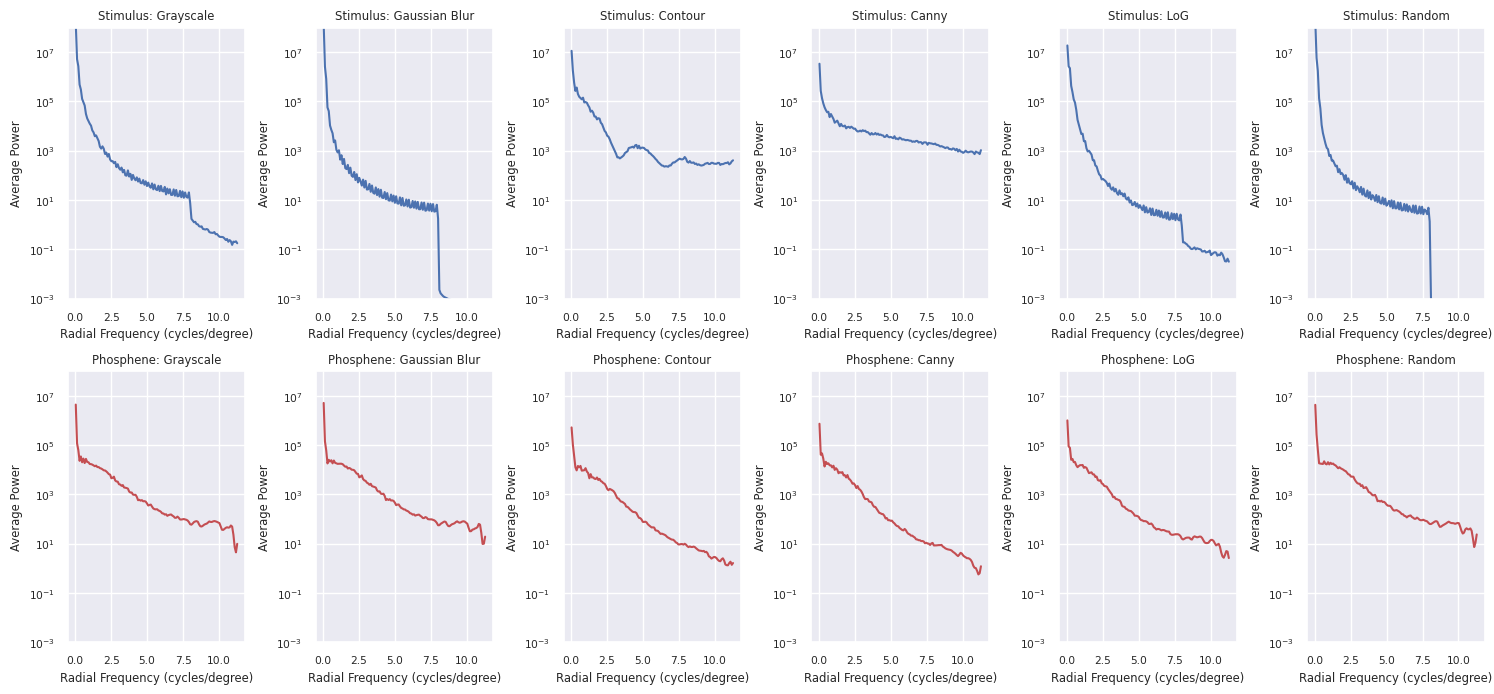

In [56]:
# calculate and plot for all the stims and phosphene images
labels = ['Grayscale', 'Gaussian Blur', 'Contour', 'Canny', 'LoG', 'Random']

# calculate and plot the radial power spectrum for each stimulus and phosphene image
plt.figure(figsize=(15, 7))
for i, (stim, phos) in enumerate(zip(stim_images, phos_images)):
    r_bins_stim, radial_profile_stim = compute_radial_power_spectrum_torch(stim[0,0], nbins=128, fov=16)
    r_bins_phos, radial_profile_phos = compute_radial_power_spectrum_torch(phos[0,0], nbins=128, fov=16)
    
    plt.subplot(2, len(labels), i+1)
    plt.plot(r_bins_stim.cpu().numpy(), radial_profile_stim.cpu().numpy(), 'b-')
    plt.xlabel('Radial Frequency (cycles/degree)')
    plt.ylabel('Average Power')
    plt.yscale('log')
    # y lim vmax=1e8
    plt.ylim(1e-3, 1e8)
    plt.title(f'Stimulus: {labels[i]}')
    
    plt.subplot(2, len(labels), i+len(labels)+1)
    plt.plot(r_bins_phos.cpu().numpy(), radial_profile_phos.cpu().numpy(), 'r-')
    plt.xlabel('Radial Frequency (cycles/degree)')
    plt.ylabel('Average Power')
    plt.yscale('log')
    plt.ylim(1e-3, 1e8)
    plt.title(f'Phosphene: {labels[i]}')

plt.tight_layout()
plt.show()